# Imports

In [3]:
import pandas as pd, numpy as np, seaborn as sns, matplotlib.pyplot as plt, matplotlib
from umap import UMAP
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
import sklearn
import hypercluster as hc
sns.set(style = 'white', color_codes=True, font_scale = 1.3)
matplotlib.rcParams.update({'savefig.bbox': 'tight', 'savefig.dpi': '500'})

### Input data and filtering

In [4]:
data = pd.read_csv('TCGA_2012_BRCA_data_expression_median_top500_most_variable.txt', sep='\t', index_col=0)

In [5]:
data.shape

(500, 526)

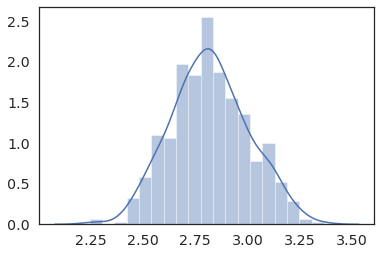

In [6]:
sns.distplot(data.std())

In [8]:
data = hc.visualize.zscore(data).transpose()

# Running with default hyperparameters

In [9]:
clusterer = hc.MultiAutoClusterer().fit(data).evaluate(evaluation_methods=hc.constants.inherent_metrics)

# Visualize evaluations

##### Across all clusterers

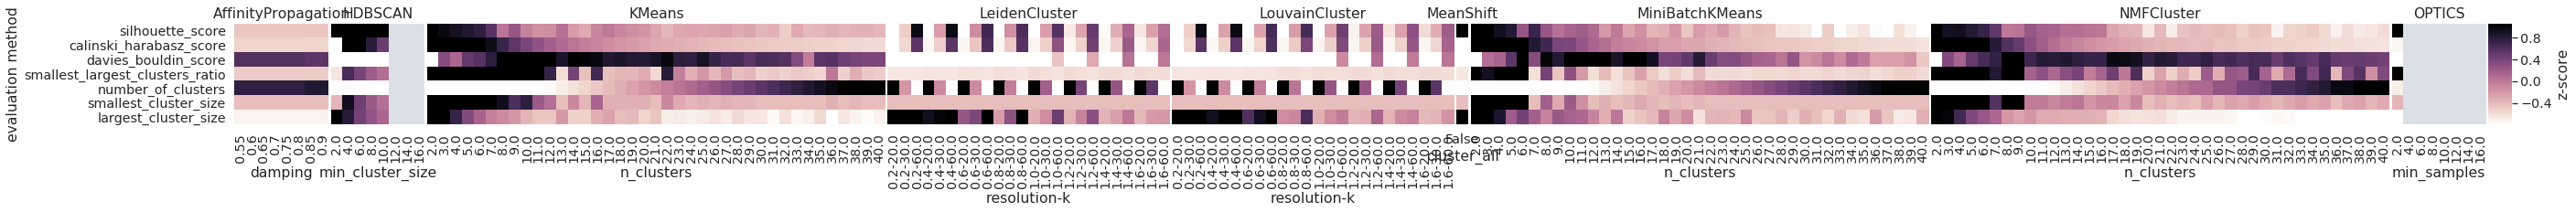

In [7]:
axs = clusterer.visualize_evaluations(savefig=True, output_prefix='figures/heatmap.brca-rna.evaluations')

#Can modify axs before saving. 
# axs[3].set_xlabel('cluster_all', va='top')


##### Making scree plots for each metric

ERROR:root:Cannot convert MeanShift data to floats, skipping visualization
/gpfs/data/ruggleslab/home/lmb529/conda/envs/phdis/lib/python3.7/site-packages/statsmodels/genmod/families/links.py:190: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/gpfs/data/ruggleslab/home/lmb529/conda/envs/phdis/lib/python3.7/site-packages/statsmodels/genmod/families/family.py:889: RuntimeWarning: divide by zero encountered in true_divide
  endog_mu = self._clean(endog / mu)
/gpfs/data/ruggleslab/home/lmb529/conda/envs/phdis/lib/python3.7/site-packages/statsmodels/genmod/families/family.py:890: RuntimeWarning: divide by zero encountered in true_divide
  n_endog_mu = self._clean((1. - endog) / (1. - mu))
ERROR:root:Cannot convert MeanShift data to floats, skipping visualization
ERROR:root:Cannot convert MeanShift data to floats, skipping visualization
/gpfs/data/ruggleslab/home/lmb529/conda/envs/phdis/lib/python3.7/site-packages/statsmodels/genmod/families/family.py:889: RuntimeWarning: overf

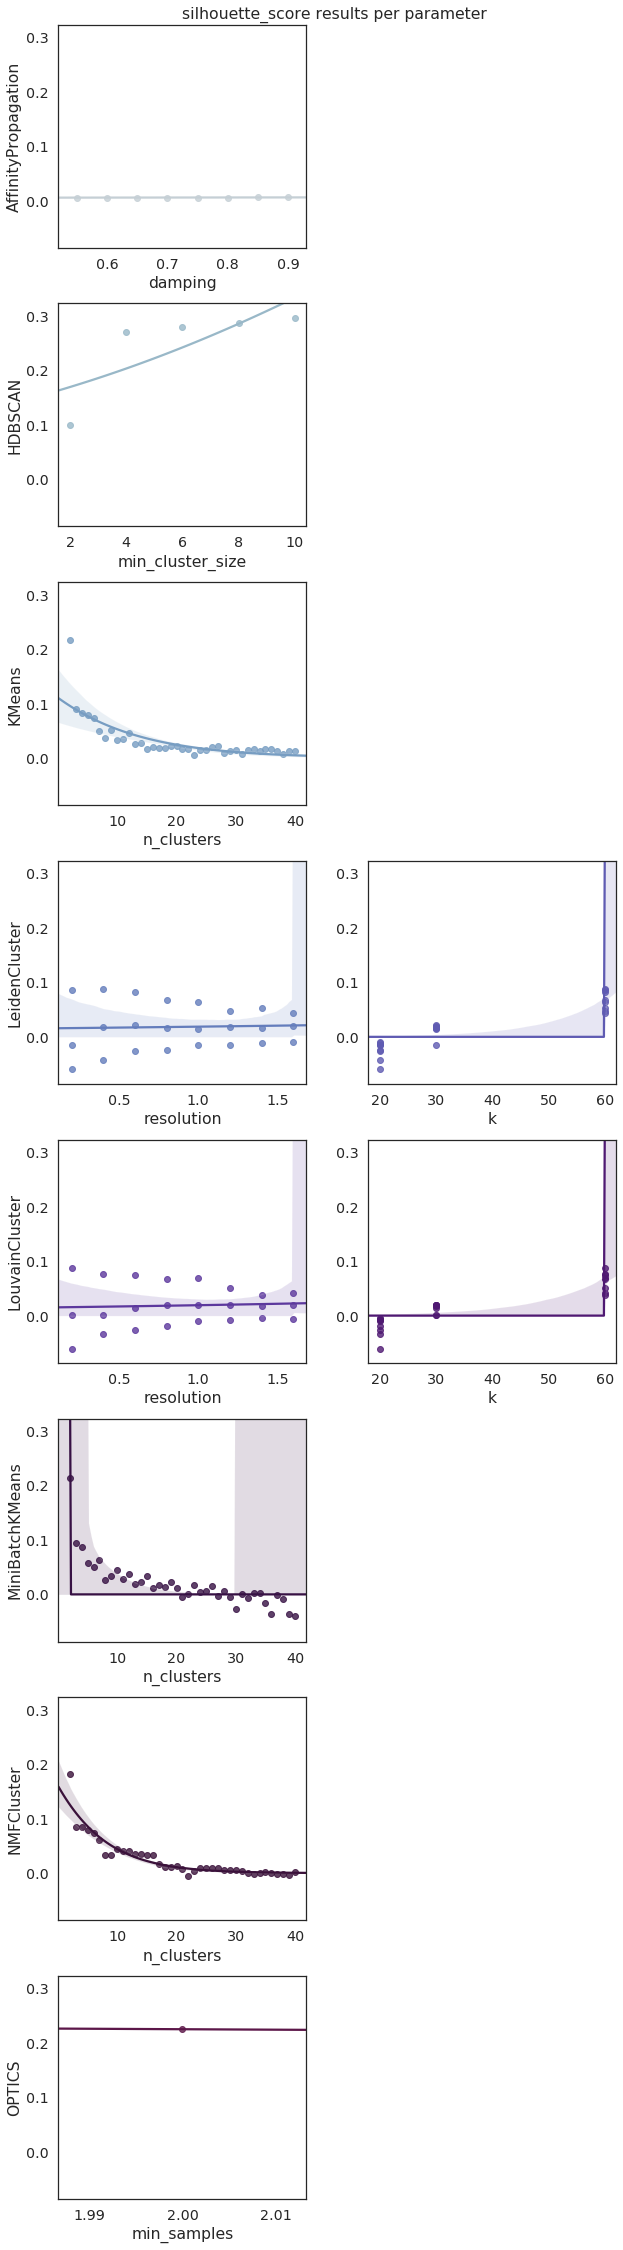

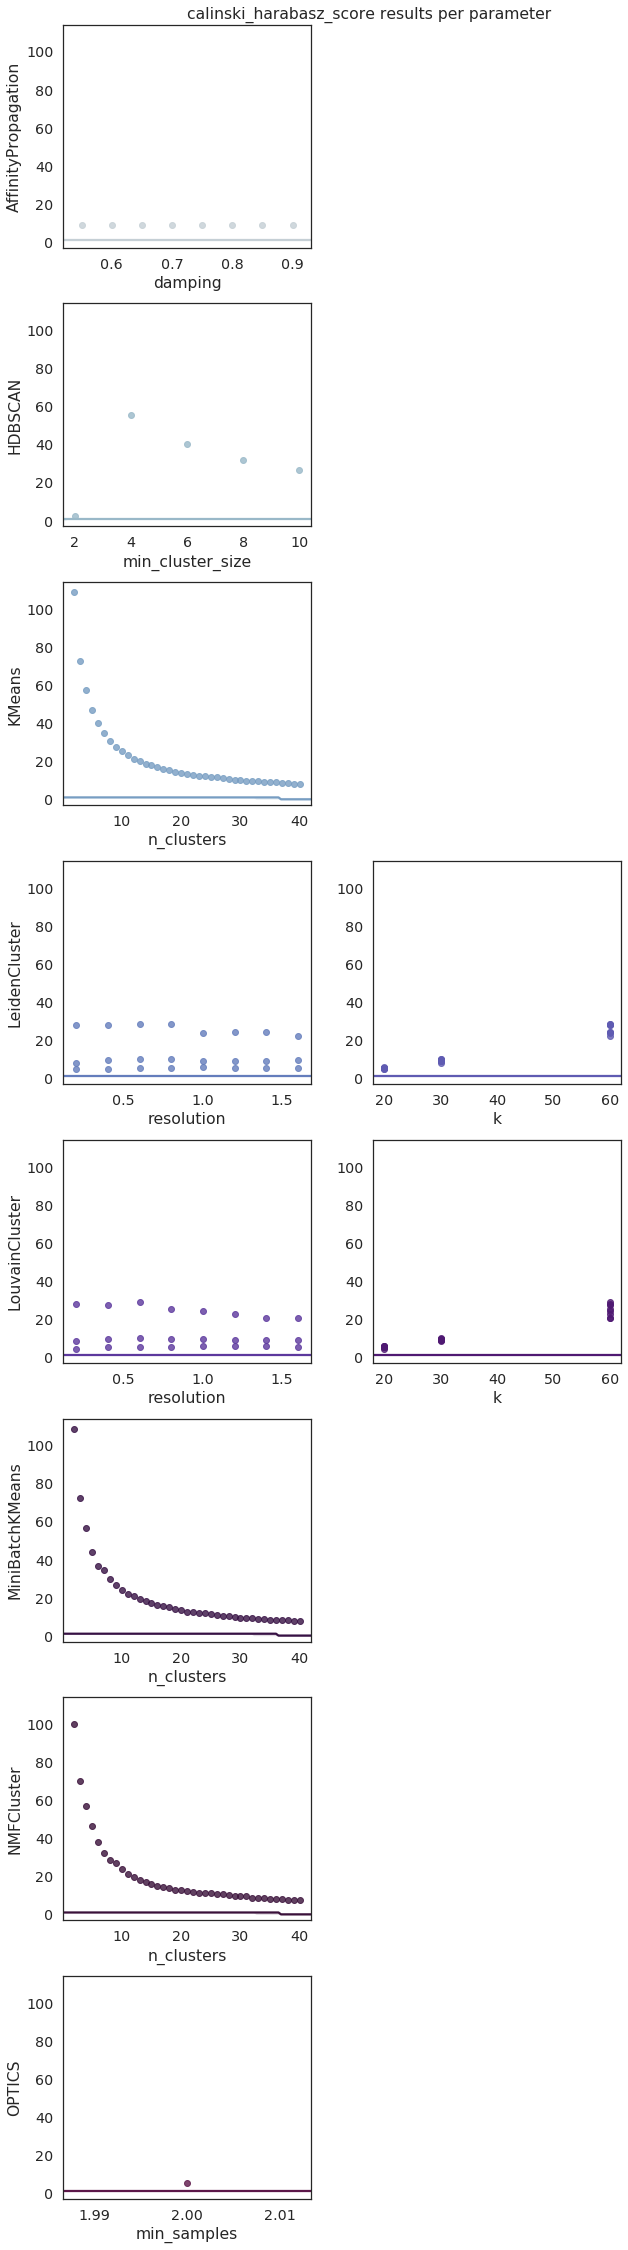

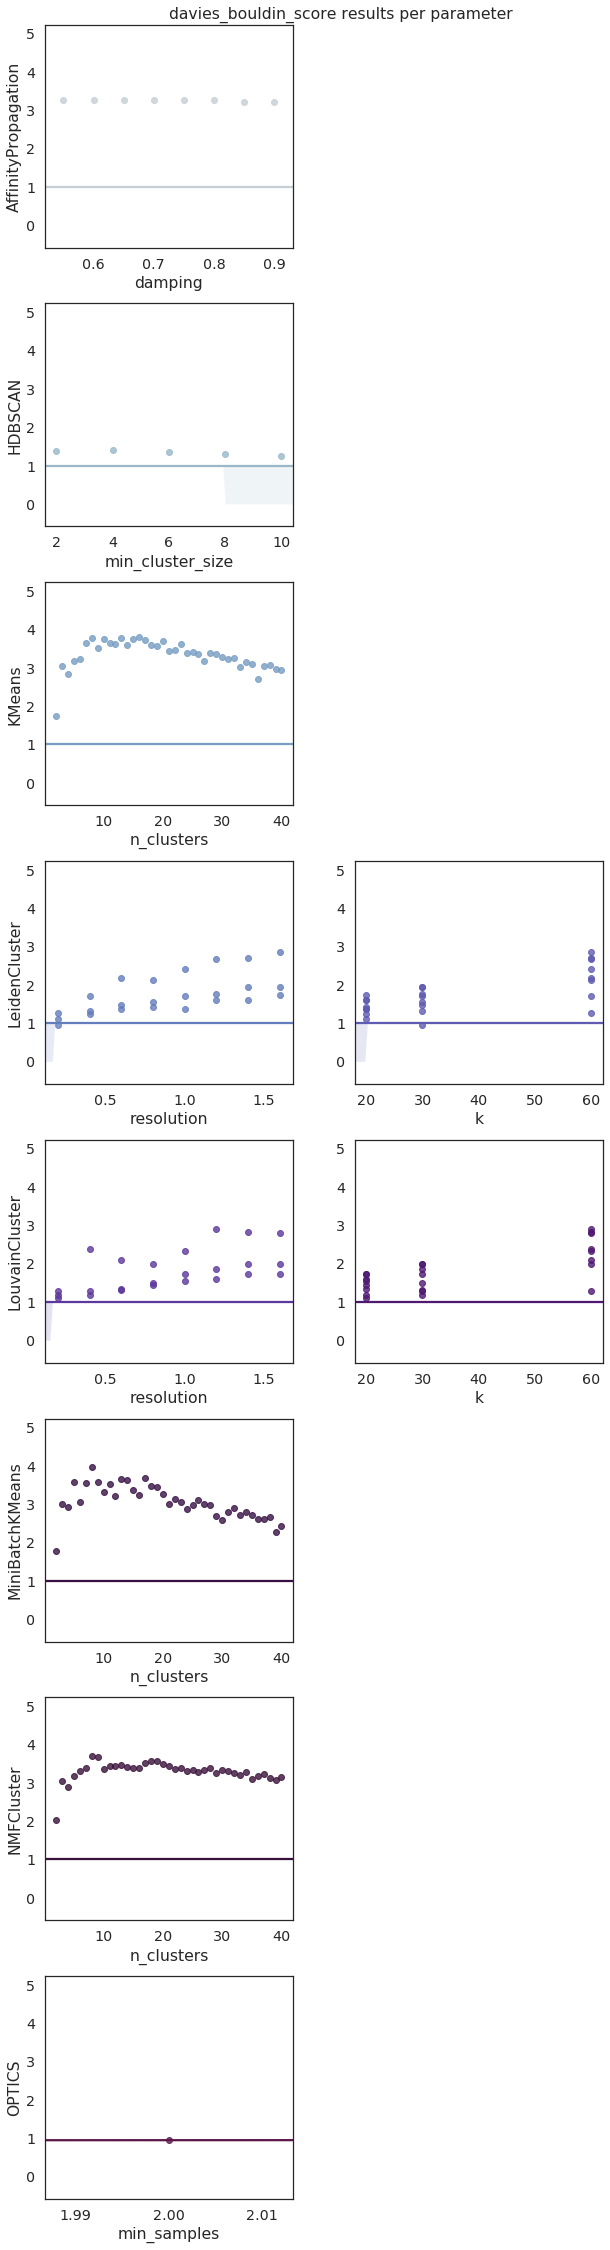

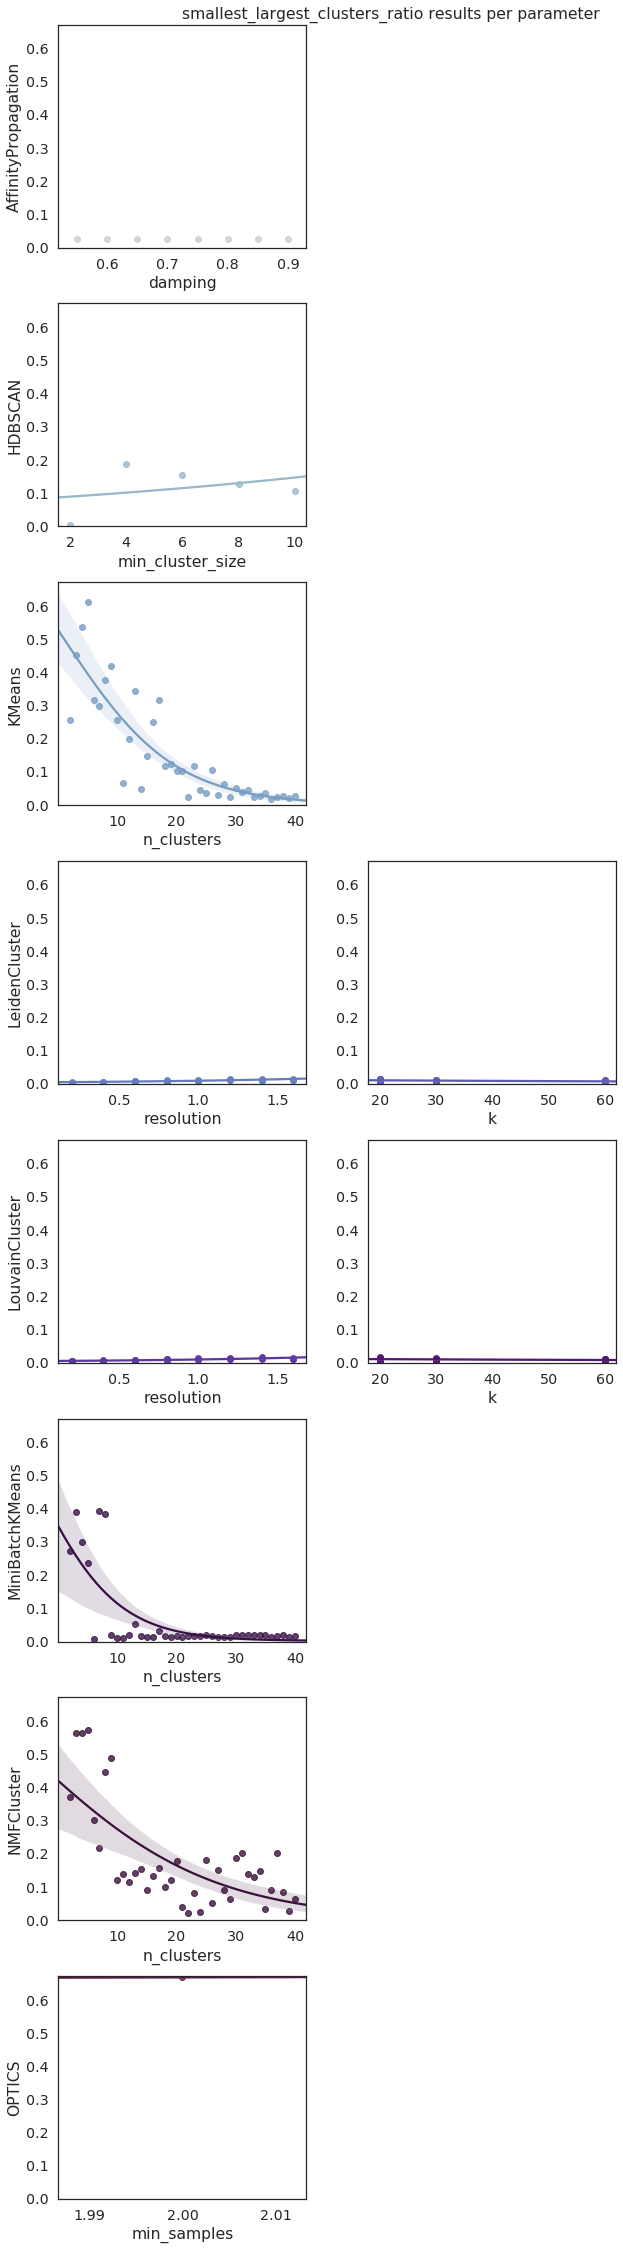

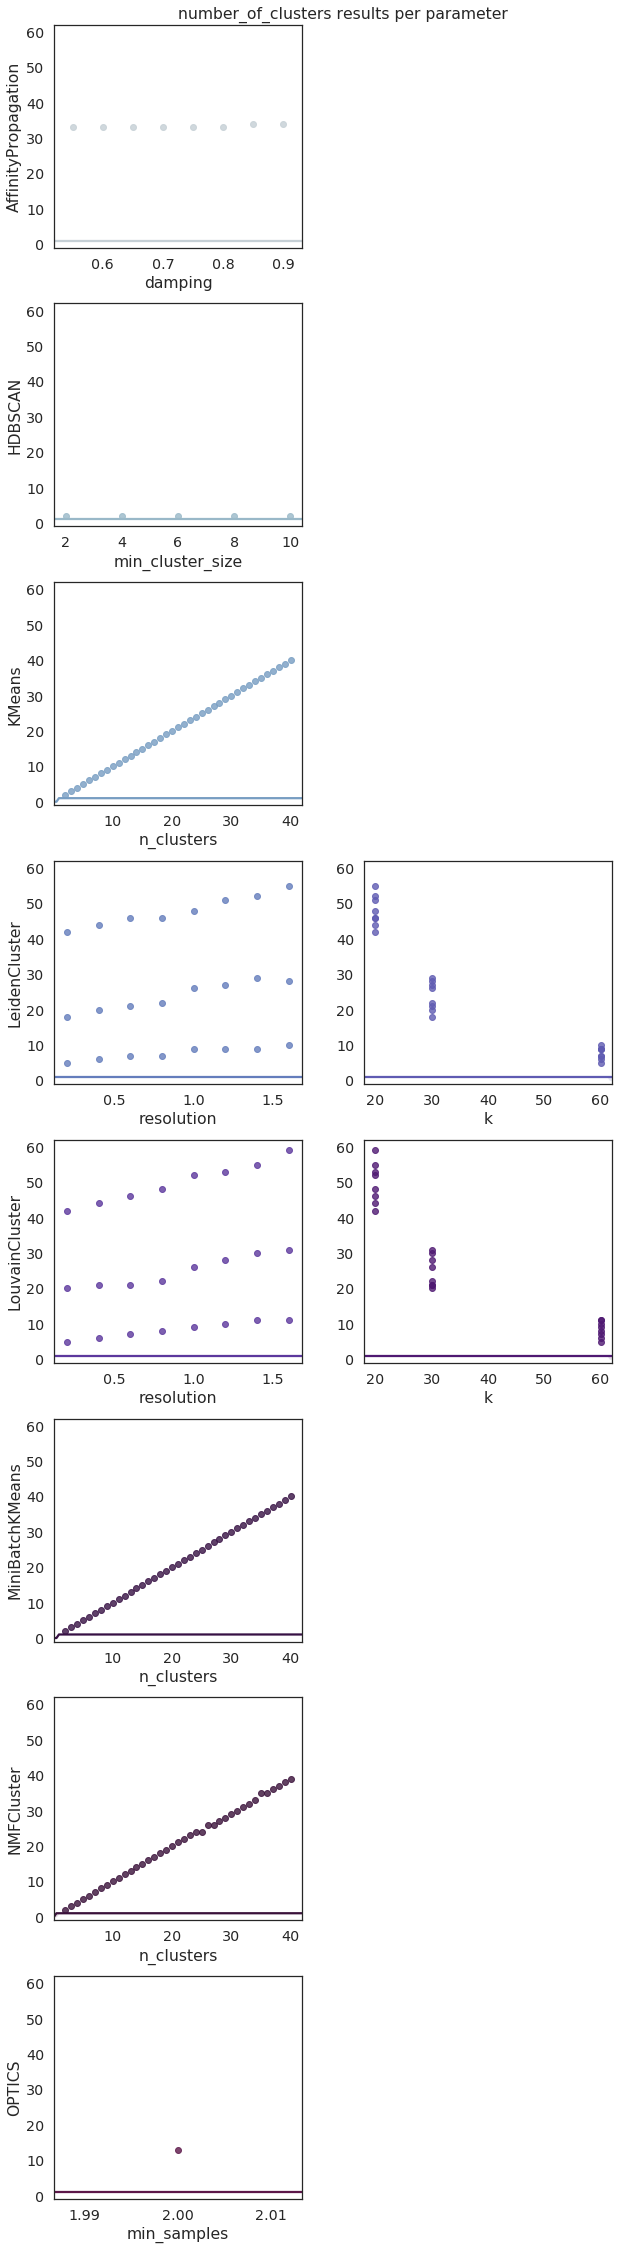

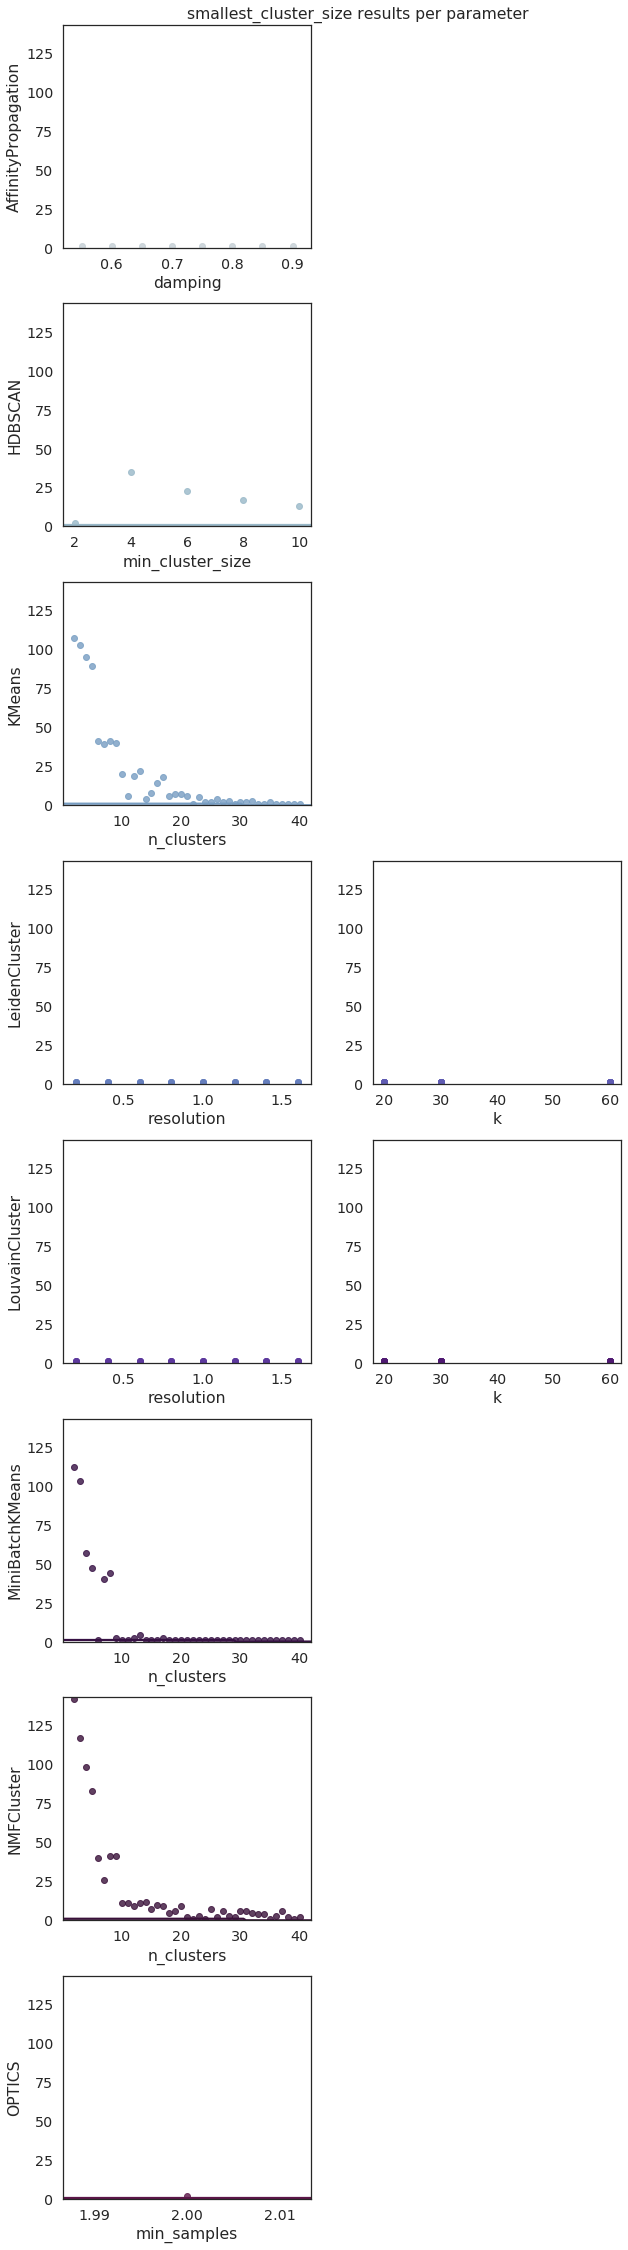

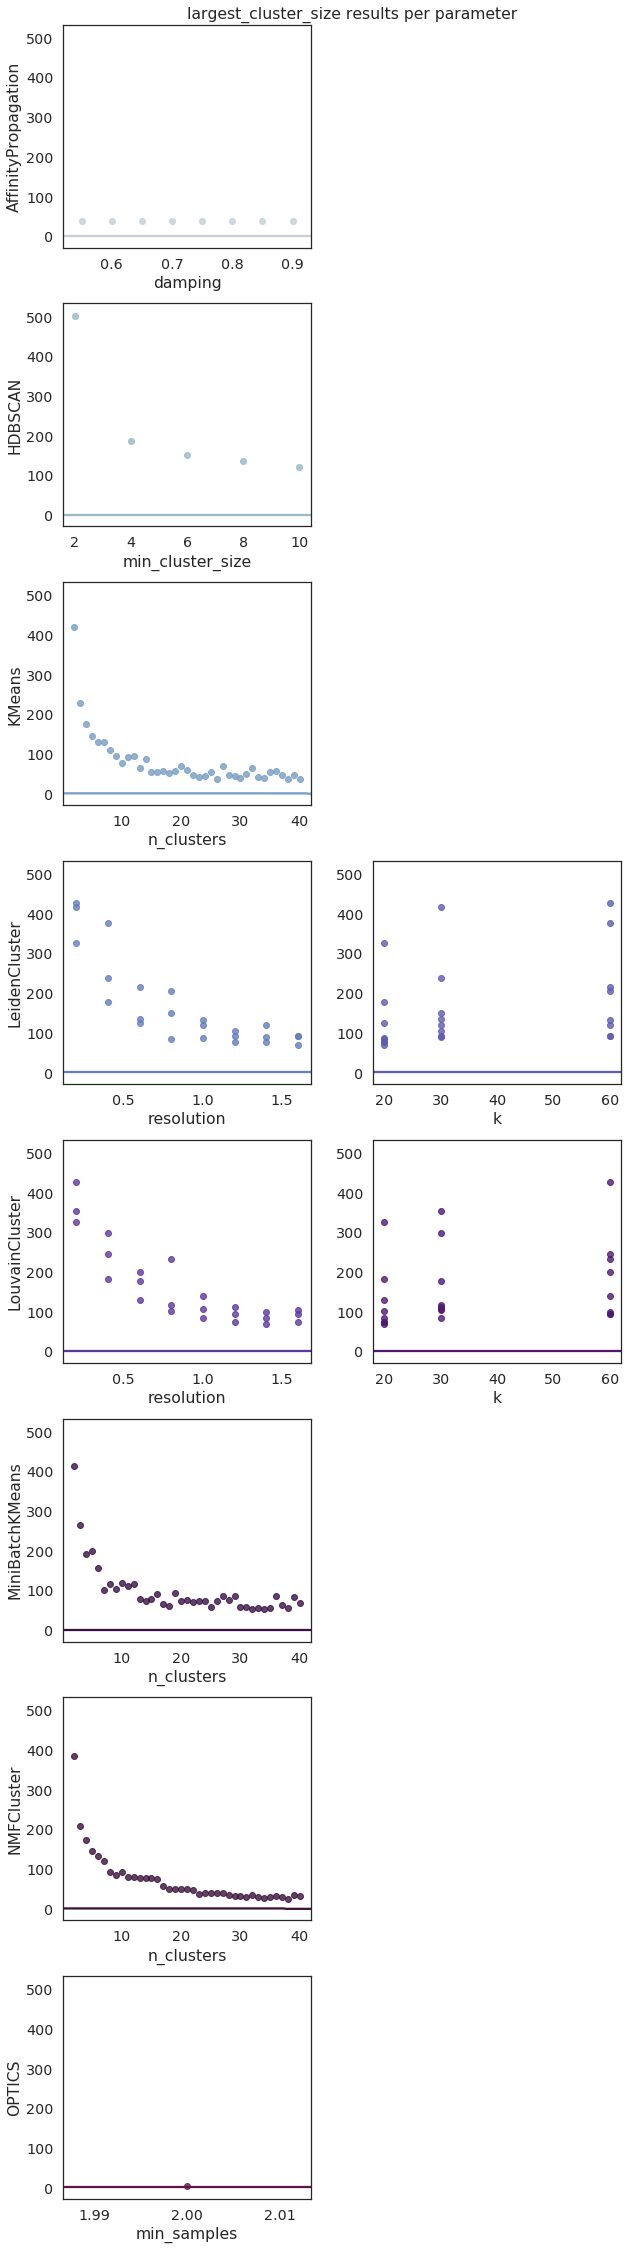

In [50]:
for metric in hc.constants.inherent_metrics:
    clusterer.visualize_for_picking_labels(metric, savefig_prefix='figures/scatter.%s' % metric)

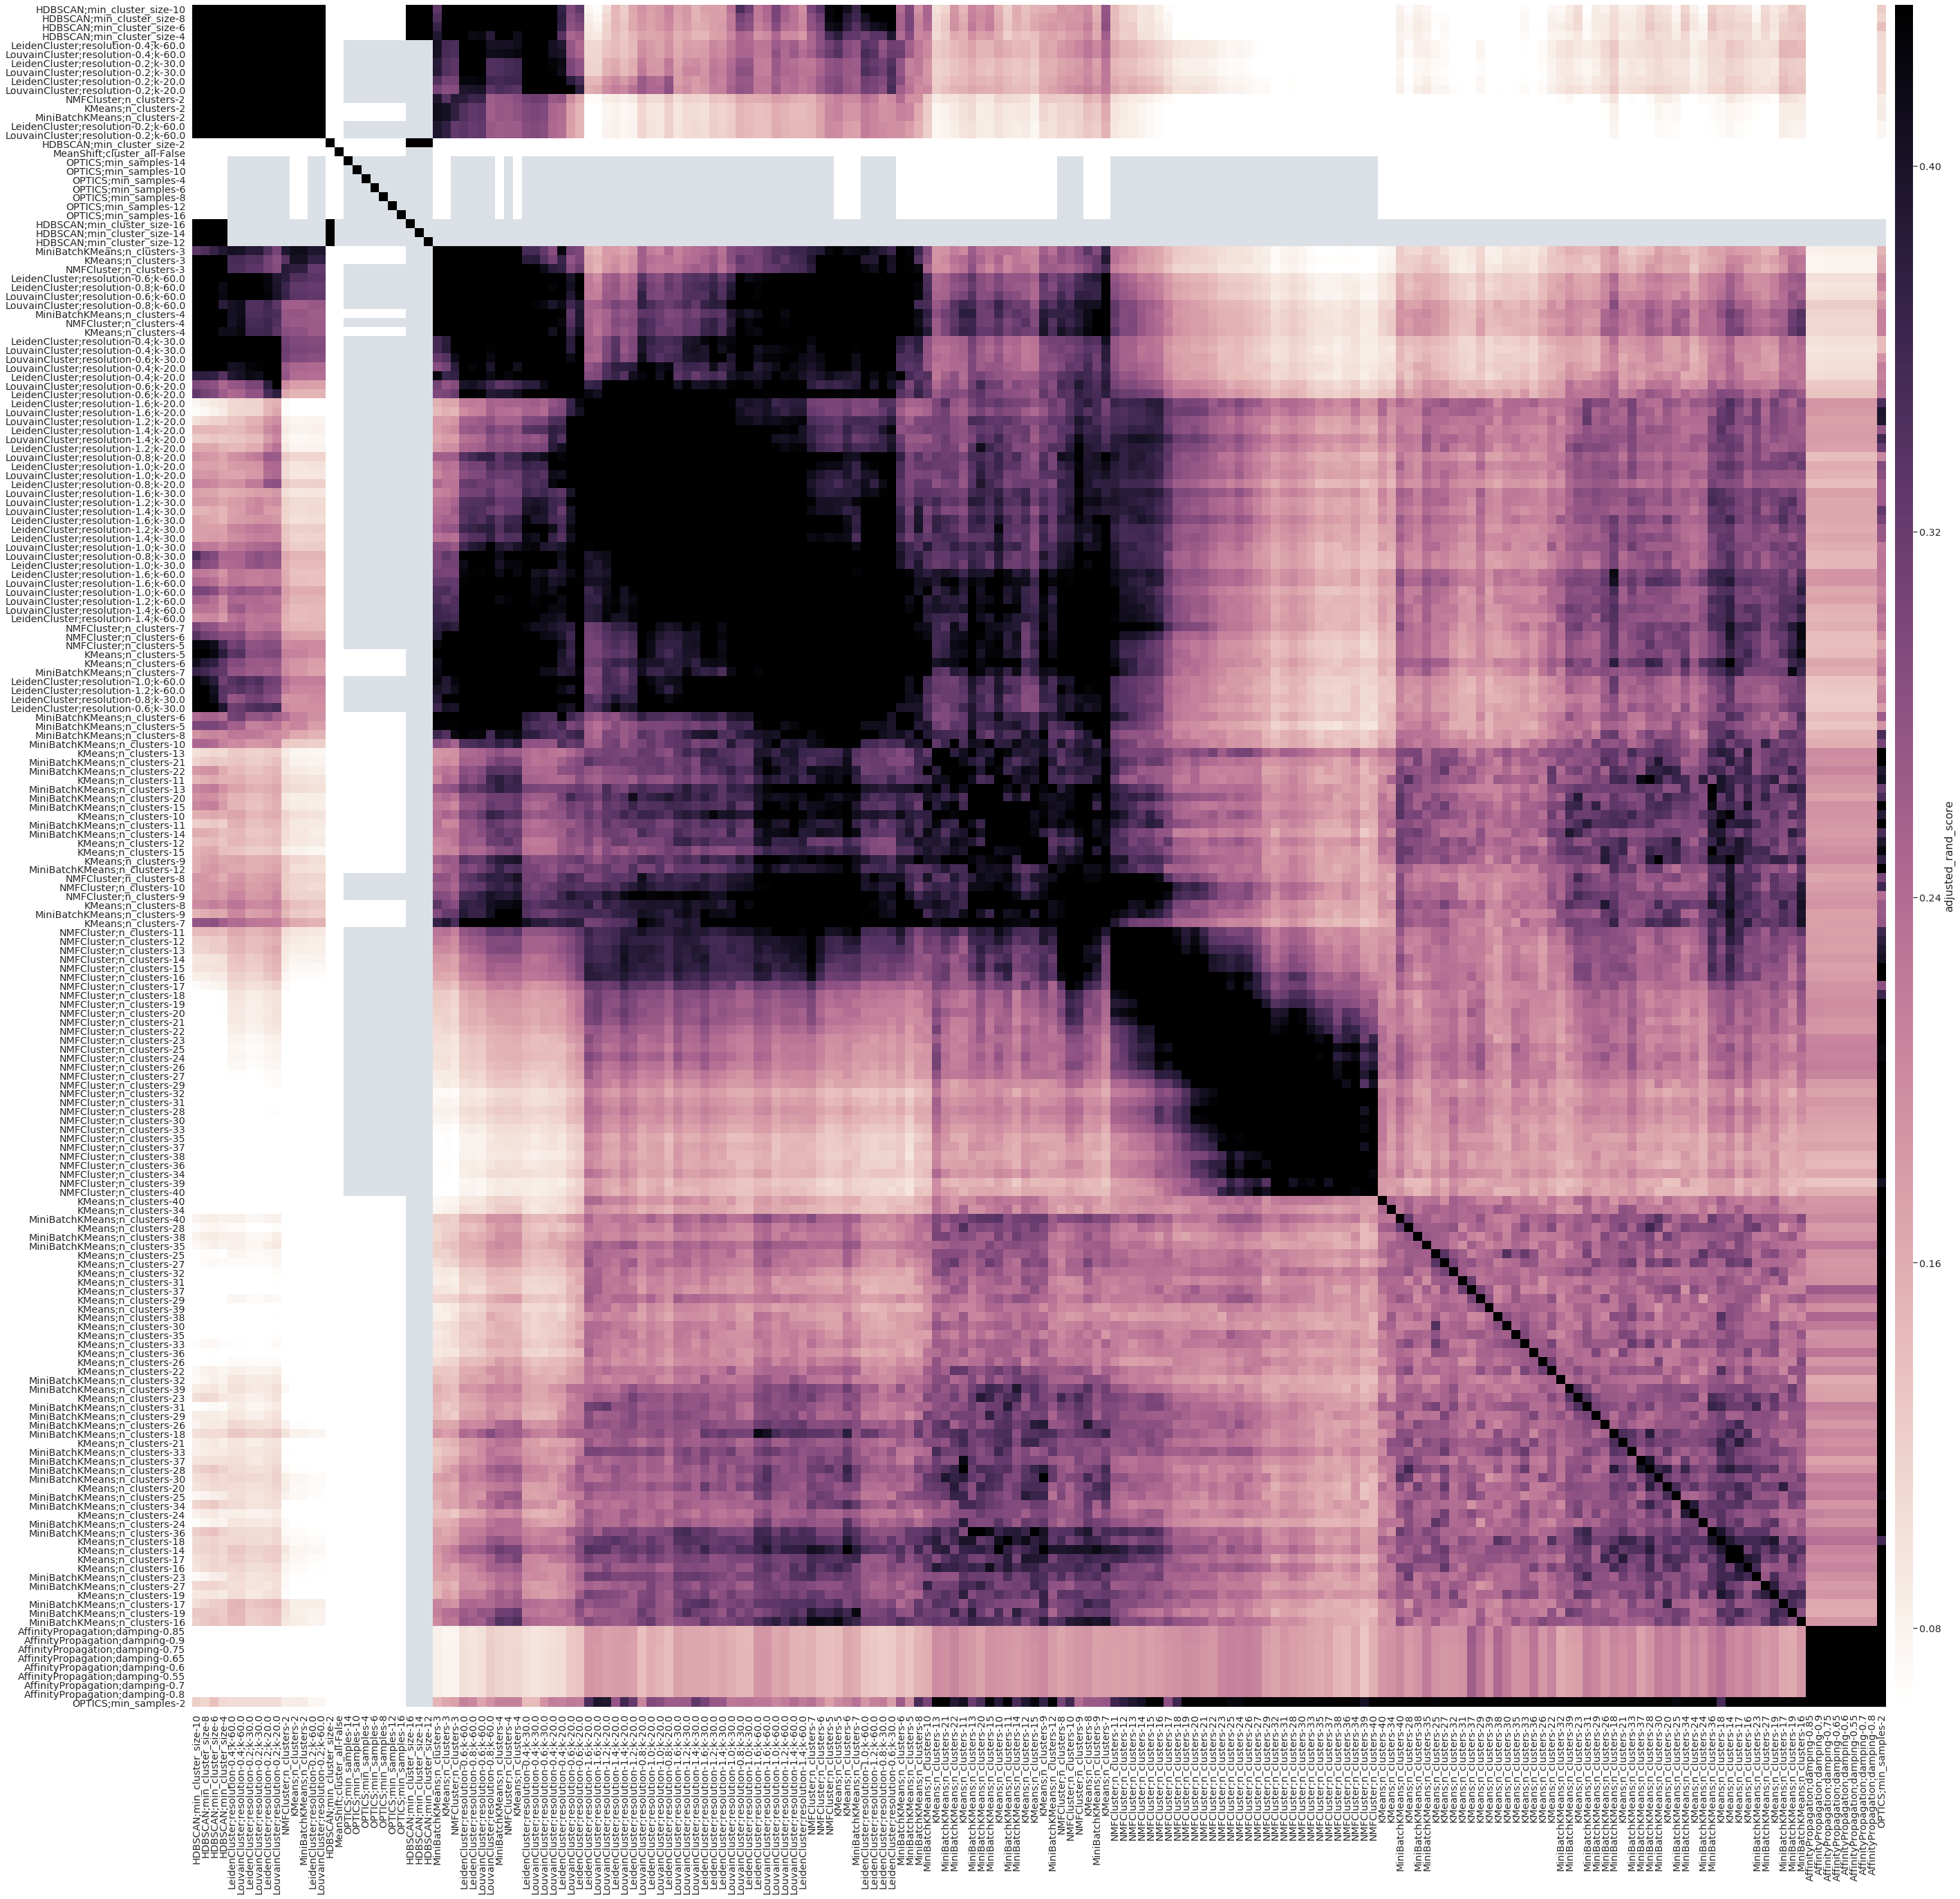

In [41]:
_ = hc.visualize.visualize_label_agreement(clusterer.labels_df.astype(float), savefig=True, output_prefix="figures/clustermap.label_agreement")

# Compare all results that have 4 clusters to PAM50 subtyping

In [11]:
annotations = pd.read_csv('data_clinical_sample.txt', sep='\t', index_col=0, skiprows=4)
data = pd.read_csv('TCGA_2012_BRCA_data_expression_median_top500_most_variable.txt', sep='\t', index_col=0).transpose()
# filtering down to visualize
data = data.loc[:, data.std()>np.percentile(data.std(), 75)]

In [12]:
conditions_with_4_clusterers = clusterer.evaluation_df.columns[clusterer.evaluation_df.loc['number_of_clusters']==4]
labels = hc.utilities.pick_best_labels(clusterer.evaluation_df[conditions_with_4_clusterers], clusterer.labels_df[conditions_with_4_clusterers], 'smallest_largest_clusters_ratio', 'max')

annotations = pd.concat([labels, annotations[['PAM50_SUBTYPE']]], join='inner', axis=1)
# .sort_values(['NMFCluster;n_clusters-4', 'PAM50_SUBTYPE'])

In [13]:
colors = {
    'Luminal A': '#3A53A5',
    'CLDN-low':'#EFC032',
    'HER2-enriched':'#B9539F',
    'Basal-like':'#EE2025',
    'Normal':'gray',
    'Luminal B':'#6ECDDE',
    'nan':'#FFFFFF',
    'Normal-like':'#BDBDBD',
    0: '#6ECDDE',
    1: '#EE2025',
    2: '#3A53A5',
    3: '#B9539F'
}

col_colors = annotations.replace(colors)

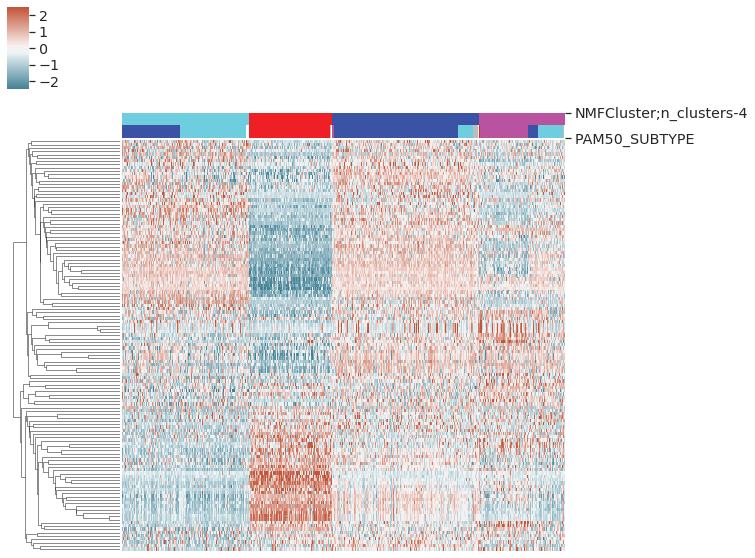

In [175]:
cg = sns.clustermap(
    hc.visualize.zscore(data.transpose().reindex(annotations.index, axis=1)), 
    col_cluster=False,
    xticklabels=False, 
    yticklabels=False, 
    col_colors=col_colors, 
    cmap=sns.diverging_palette(220, 20, sep=20, as_cmap=True), 
    vmin=-2.5, vmax=2.5
)
cg.ax_heatmap.set_ylabel('')
cg.savefig('figures/clustermap.nmf4-vs-psm50.pdf')

In [19]:
clusterer.evaluate(hc.constants.inherent_metrics+hc.constants.need_ground_truth, gold_standard=annotations.dropna(how='any')['PAM50_SUBTYPE'])

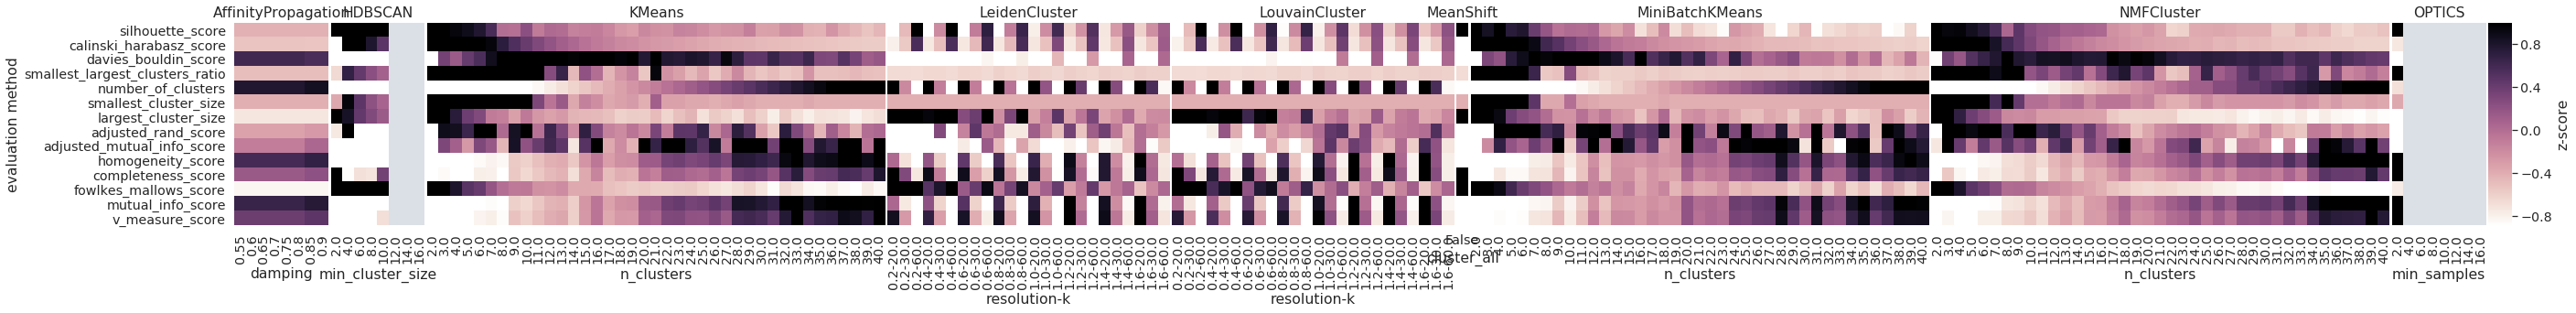

In [42]:
axs = clusterer.visualize_evaluations(savefig=True, output_prefix='figures/heatmap.brca-rna.evaluations.PAM50_comp')

In [172]:
for metric in hc.constants.need_ground_truth:
    print(
        metric, 
        hc.utilities.evaluate_one(
                annotations.dropna(how='any')['NMFCluster;n_clusters-4'], 
                metric, 
                gold_standard=annotations.dropna(how='any')['PAM50_SUBTYPE']
        )
    )

adjusted_rand_score 0.45275025130906915
adjusted_mutual_info_score 0.5443359514541736
homogeneity_score 0.5543568421499789
completeness_score 0.5427109379515125
fowlkes_mallows_score 0.6080789333660002
mutual_info_score 0.7359088332378102
v_measure_score 0.5484720766026344


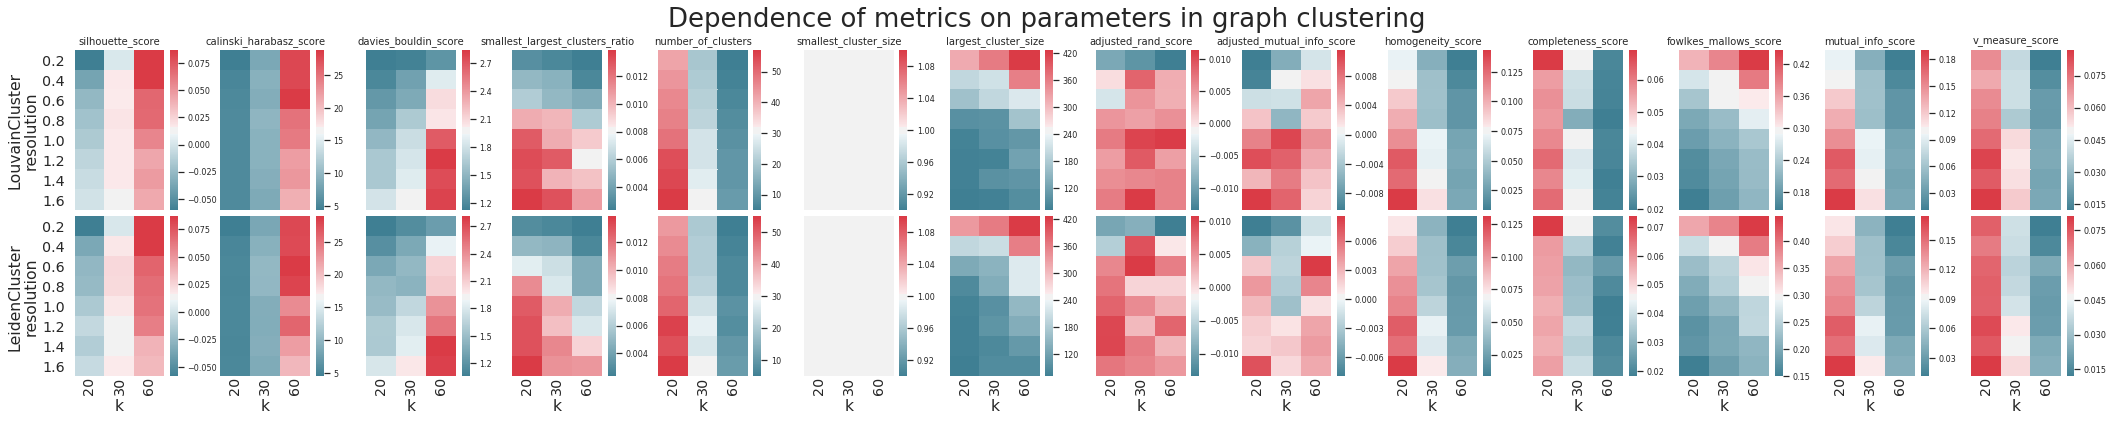

In [233]:
cmap = sns.diverging_palette(220, 10, as_cmap=True)
cmap.set_bad('#BDBDBD')
cmap.set_over('#9E031A')
cmap.set_under('#0C4A60')

fig, axs = plt.subplots(
    ncols = len(clusterer.evaluation_methods), 
    nrows=2,
    figsize=(4*len(clusterer.evaluation_), 6),
    gridspec_kw=dict(hspace=0.04, wspace=0.3),
    sharey=True, sharex=True
)

for row, method in enumerate(['LouvainCluster', 'LeidenCluster']):
    df = clusterer.evaluation_[method].transpose()
    for col, metric in enumerate(df.columns):
        ax = axs[row, col]
        visdf = df[metric].unstack()
        sns.heatmap(visdf, xticklabels=visdf.columns,yticklabels=visdf.index, cmap=cmap, ax=ax)
        cbar = ax.collections[0].colorbar
        cbar.ax.tick_params(labelsize=8)
        if col > 0:
            ax.set_ylabel('')
        if row == 0:
            ax.set_xlabel('')
            ax.set_title(metric, fontsize=10)
        ax.set_yticklabels(visdf.index, rotation=0)
        ax.set_xticklabels([int(i) for i in visdf.columns], rotation=90, va='center')
        
axs[0,0].text(-0.75, 0.5, 'LouvainCluster', rotation=90, va='center', transform=axs[0,0].transAxes)
axs[1,0].text(-0.75, 0.5, 'LeidenCluster', rotation=90, va='center', transform=axs[1,0].transAxes)

fig.suptitle('Dependence of metrics on parameters in graph clustering', y=0.98,  fontsize=26)
plt.savefig('figures/heatmaps.graphs-clusterers.metrics.pdf')

# Visualize clusters with dimensionality reduction

In [12]:
data = pd.read_csv('TCGA_2012_BRCA_data_expression_median_top500_most_variable.txt', sep='\t', index_col=0)
data = hc.visualize.zscore(data).transpose()

## Louvain and UMAP

In [234]:
method = 'LouvainCluster'
metric = 'adjusted_rand_score'

# method = 'LeidenCluster'
# metric = 'silhouette_score'

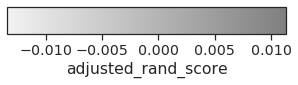

In [235]:
evals = clusterer.evaluation_[method].loc[metric, :]

umap = UMAP(n_components=2).fit_transform(data)
umap = pd.DataFrame(umap, index=data.index, columns=['UMAP1', 'UMAP2'])

params = clusterer.labels_[method].transpose().index
ks = sorted(list(set(params.get_level_values(1))))
ress = sorted(list(set(params.get_level_values(0))))

sm = ScalarMappable(
    norm=Normalize(vmin=evals.min(), vmax=evals.max()), 
    cmap=sns.light_palette('gray', as_cmap=True), 
)
facecolors = sm.to_rgba(evals)
fig, ax = plt.subplots(figsize=(5, 0.5))
plt.colorbar(mappable=sm, label=metric, cax=ax, orientation='horizontal')
plt.savefig('figures/colorbar.%s-%s.pdf' % (method, metric))

/gpfs/data/ruggleslab/home/lmb529/conda/envs/hc_test/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


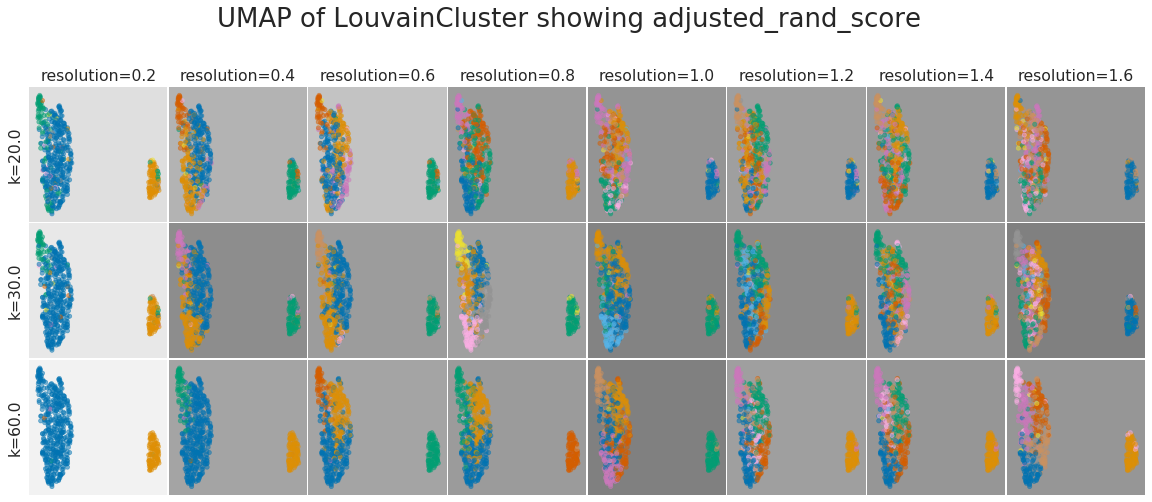

In [236]:
fig, axs = plt.subplots(
    figsize=(2.5*len(ress), 2.5*len(ks)),
    nrows=len(ks),
    ncols=len(ress),
    sharex=True,
    sharey=True,
    gridspec_kw=dict(
        hspace=0.01, wspace=0.01,
    )
)

for row, k in enumerate(ks):
    for col, resolution in enumerate(ress):
        facecolor = matplotlib.colors.to_hex(facecolors[evals.index.get_loc((resolution, k))])
        ax = axs[row, col]
        temp = clusterer.labels_[method][[(resolution, k)]]
        temp.columns = ['%s;%s-%s;%s-%s' % (method,'resolution', resolution, 'k', k)]
        temp.loc[:, temp.columns[0]] = temp[temp.columns[0]].astype(str)
        temp = pd.concat([temp, umap], axis=1)
        
        sns.scatterplot(
            x='UMAP1',
            y='UMAP2',
            hue=temp.columns[0],
            palette=sns.color_palette('colorblind', n_colors=len(temp[temp.columns[0]].unique())),
            data=temp,
            ax=ax,
            size=25,
            legend=False,
            alpha=0.5,
            edgecolor=None
        )
        if col == 0:
            axs[row, 0].text(-0.05, 0.5, '%s=%s' % ('k', k), va='center', ha='right',rotation=90, transform=ax.transAxes)
        
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
            
        for spine in ax.spines.values():
            spine.set_visible(False)
            
        ax.patch.set_facecolor(facecolor)

        if row == 0:
            ax.set_title('%s=%s' % ('resolution', resolution))
fig.suptitle('UMAP of %s showing %s' % (method, metric), fontsize=26, va='bottom')
plt.savefig('figures/grid.scatter.%s-%s-umaps.pdf' %(method, metric))

## NMF clustering and PCA

In [17]:
method = 'NMFCluster'
# metric = 'silhouette_score'
metric = 'adjusted_rand_score'

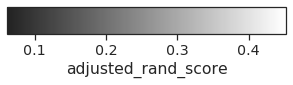

In [20]:
evals = clusterer.evaluation_[method].loc[metric, :]

pca_model = sklearn.decomposition.PCA(n_components=2)
pca = pca_model.fit_transform(data)
pca = pd.DataFrame(pca, index=data.index, columns=['PCA1', 'PCA2'])

sm = ScalarMappable(
    norm=Normalize(vmin=evals.min(), vmax=evals.max()), 
    cmap=sns.dark_palette('white', as_cmap=True), 
)

facecolors = sm.to_rgba(evals)
fig, ax = plt.subplots(figsize=(5, 0.5))
plt.colorbar(mappable=sm, label=metric, cax=ax, orientation='horizontal')
plt.savefig('figures/colorbar.%s-%s.pdf' % (method, metric))

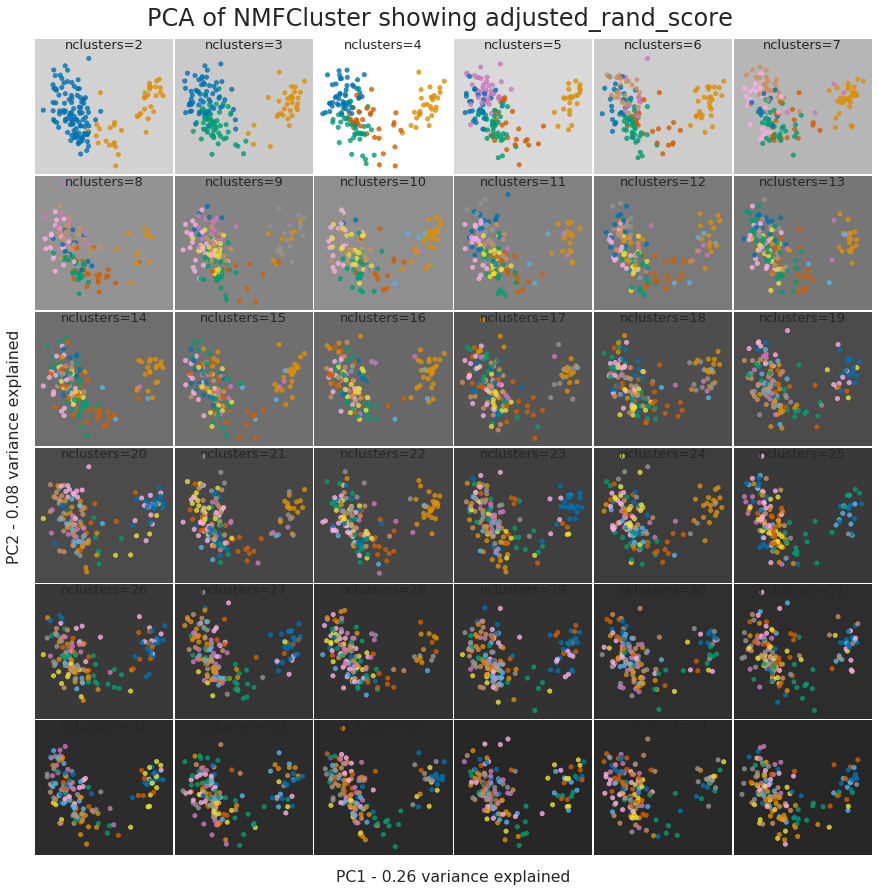

In [14]:
fig, axs = plt.subplots(
    figsize=(2.5*6, 2.5*6),
    nrows=6,
    ncols=6,
    sharex=True,
    sharey=True,
    gridspec_kw=dict(
        hspace=0.01, wspace=0.01,
    )
)
axs = [ax for lis in axs for ax in lis]

for i, n_clusters in enumerate(range(2, 38)):

    facecolor = matplotlib.colors.to_hex(facecolors[i])
    ax = axs[i]
    temp = clusterer.labels_[method][[n_clusters]].astype(float)
    temp = pd.concat([temp, pca], axis=1).sample(150)

    sns.scatterplot(
        x='PCA1',
        y='PCA2',
        hue=temp.columns[0],
        palette=sns.color_palette('colorblind', n_colors=len(temp[temp.columns[0]].unique())),
        data=temp,
        ax=ax,
        size=28.5,
        legend=False,
        alpha=0.8,
        edgecolor=None
    )

    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)

    for spine in ax.spines.values():
        spine.set_visible(False)

    ax.patch.set_facecolor(facecolor)

    ax.set_title('%s=%s' % ('nclusters', n_clusters), va='top', fontsize=13, pad=0.1)
    
axs[32].text(1, -0.2, 'PC1 - %.2f variance explained' %(pca_model.explained_variance_ratio_[0]), ha='center', transform=axs[32].transAxes)
axs[12].text(-0.2, 0, 'PC2 - %.2f variance explained' %(pca_model.explained_variance_ratio_[1]), va='center', rotation=90, transform=axs[12].transAxes)
fig.suptitle('PCA of %s showing %s' % (method, metric), fontsize=24, y=0.91)
plt.savefig('figures/grid.scatter.%s-%s-pcas.pdf' %(method, metric))

In [14]:
colors = {
    'Luminal A': '#3A53A5',
    'CLDN-low':'#EFC032',
    'HER2-enriched':'#B9539F',
    'Basal-like':'#EE2025',
    'Normal':'gray',
    'Luminal B':'#6ECDDE',
    'nan':'#FFFFFF',
    'Normal-like':'#BDBDBD',
    0: '#6ECDDE',
    1: '#EE2025',
    2: '#3A53A5',
    3: '#B9539F'
}

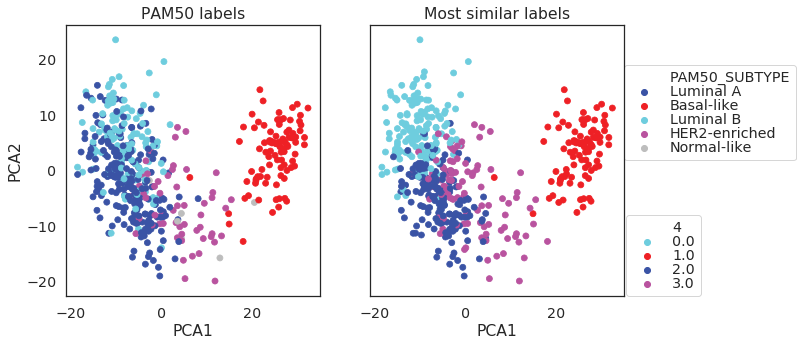

In [32]:
temp = clusterer.labels_[method][[4]].astype(float)
temp = pd.concat([temp, pca], axis=1)
fig, axs = plt.subplots(figsize=(10, 5), ncols=2, sharey=True)
sns.scatterplot(
        x='PCA1',
        y='PCA2',
        hue=annotations['PAM50_SUBTYPE'].reindex(temp.index),
        palette=colors,
        data=temp,
        ax=axs[0],
#         size=28.5,
#         legend=False,
#         alpha=0.5,
        edgecolor=None
    )
axs[0].legend(loc=(2.2, 0.5), labelspacing=0)
axs[0].set_title('PAM50 labels')
sns.scatterplot(
        x='PCA1',
        y='PCA2',
        hue=4,
        palette=colors,
        data=temp,
        ax=axs[1],
#         size=28.5,
#         legend=False,
#         alpha=0.5,
        edgecolor=None
    )
axs[1].legend(loc=(1.01, 0), labelspacing=0)
axs[1].set_title('Most similar labels')
plt.savefig('figures/scatter.pam50.best_labels.pdf')

# Clustering with PCA transformed data

In [40]:
annotations = pd.read_csv('data_clinical_sample.txt', sep='\t', index_col=0, skiprows=4)
data = pd.read_csv('TCGA_2012_BRCA_data_expression_median_top500_most_variable.txt', sep='\t', index_col=0)
data = hc.visualize.zscore(data).transpose()

In [7]:
pca_model = sklearn.decomposition.PCA(n_components=100)
pca_model.fit(data)

PCA(copy=True, iterated_power='auto', n_components=100, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

(0, 0.22)

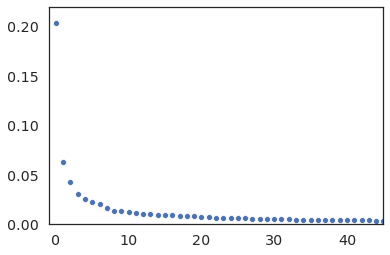

In [25]:
sns.scatterplot(list(range(0,100)), pca_model.explained_variance_ratio_)
plt.xlim(-1, 45)
plt.ylim(0, 0.22)

In [32]:
pca_model = sklearn.decomposition.PCA(n_components=20)
embedding = pca_model.fit_transform(data)

pca_data = pd.DataFrame(embedding, index=data.index, columns = ['PC%s' % (i+1) for i in range(20)])

In [42]:
clusterer = hc.MultiAutoClusterer().fit(pca_data).evaluate(
    evaluation_methods=hc.constants.inherent_metrics+hc.constants.need_ground_truth,
    gold_standard=annotations.dropna(how='any')['PAM50_SUBTYPE']
)

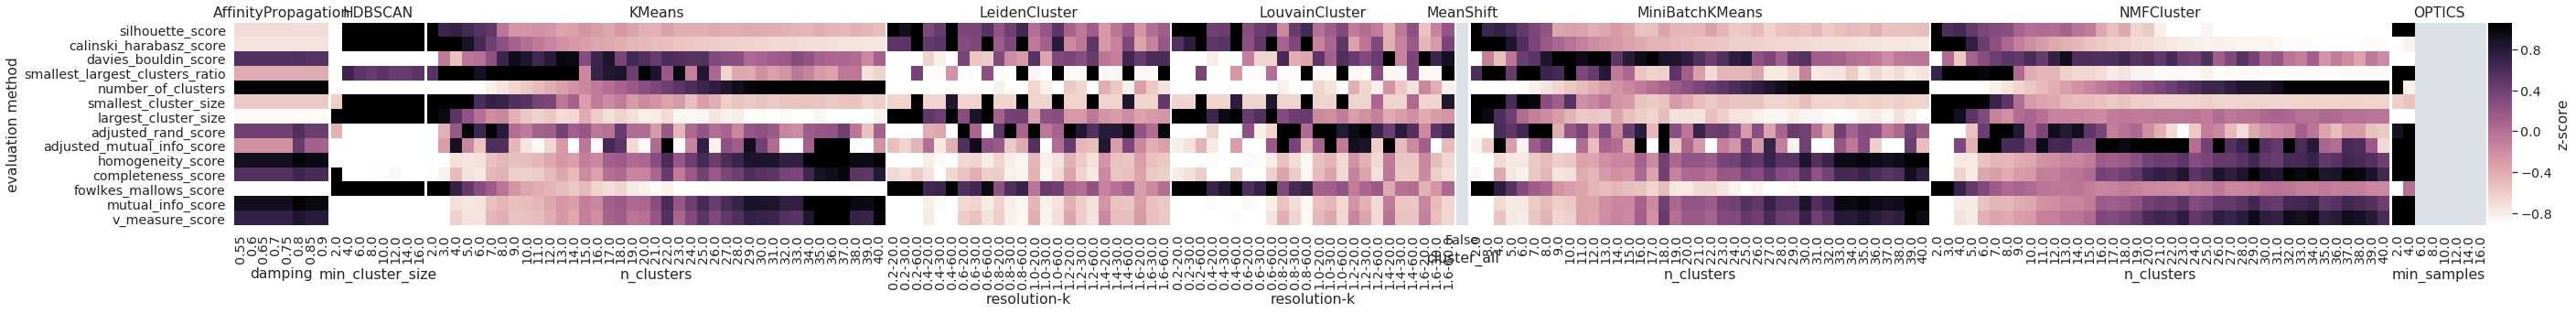

In [43]:
axs = clusterer.visualize_evaluations(savefig=True, output_prefix='figures/heatmap.brca-rna-pca.evaluations')

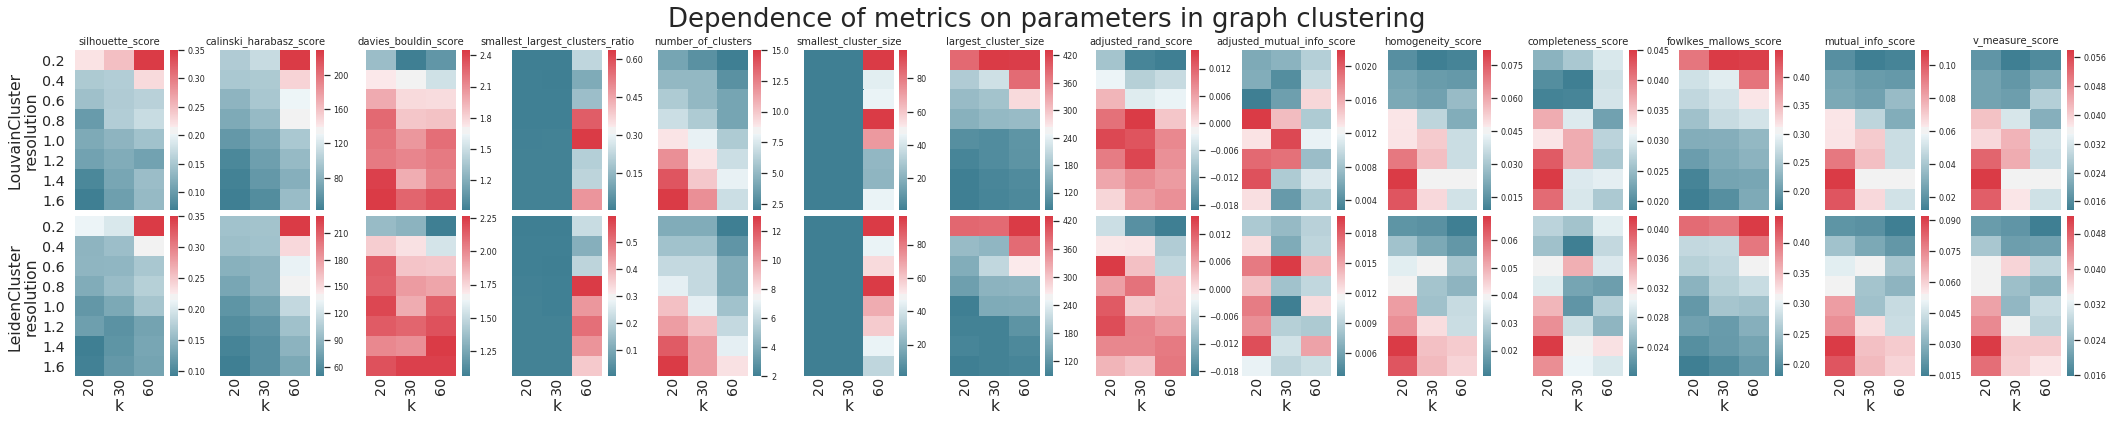

In [45]:
cmap = sns.diverging_palette(220, 10, as_cmap=True)
cmap.set_bad('#BDBDBD')
cmap.set_over('#9E031A')
cmap.set_under('#0C4A60')

fig, axs = plt.subplots(
    ncols = len(clusterer.evaluation_methods), 
    nrows=2,
    figsize=(4*len(clusterer.evaluation_), 6),
    gridspec_kw=dict(hspace=0.04, wspace=0.3),
    sharey=True, sharex=True
)

for row, method in enumerate(['LouvainCluster', 'LeidenCluster']):
    df = clusterer.evaluation_[method].transpose()
    for col, metric in enumerate(df.columns):
        ax = axs[row, col]
        visdf = df[metric].unstack()
        sns.heatmap(visdf, xticklabels=visdf.columns,yticklabels=visdf.index, cmap=cmap, ax=ax)
        cbar = ax.collections[0].colorbar
        cbar.ax.tick_params(labelsize=8)
        if col > 0:
            ax.set_ylabel('')
        if row == 0:
            ax.set_xlabel('')
            ax.set_title(metric, fontsize=10)
        ax.set_yticklabels(visdf.index, rotation=0)
        ax.set_xticklabels([int(i) for i in visdf.columns], rotation=90, va='center')
        
axs[0,0].text(-0.75, 0.5, 'LouvainCluster', rotation=90, va='center', transform=axs[0,0].transAxes)
axs[1,0].text(-0.75, 0.5, 'LeidenCluster', rotation=90, va='center', transform=axs[1,0].transAxes)

fig.suptitle('Dependence of metrics on parameters in graph clustering', y=0.98,  fontsize=26)
plt.savefig('figures/heatmaps.brca-pca.graphs-clusterers.metrics.pdf')

ERROR:root:Score silhouette_score is missing for clusterer MeanShift, skipping visualization
/gpfs/data/ruggleslab/home/lmb529/conda/envs/hc_test/lib/python3.7/site-packages/statsmodels/genmod/families/links.py:190: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/gpfs/data/ruggleslab/home/lmb529/conda/envs/hc_test/lib/python3.7/site-packages/statsmodels/genmod/families/family.py:889: RuntimeWarning: divide by zero encountered in true_divide
  endog_mu = self._clean(endog / mu)
/gpfs/data/ruggleslab/home/lmb529/conda/envs/hc_test/lib/python3.7/site-packages/statsmodels/regression/_tools.py:108: RuntimeWarning: divide by zero encountered in double_scalars
  scale = np.dot(wresid, wresid) / df_resid
/gpfs/data/ruggleslab/home/lmb529/conda/envs/hc_test/lib/python3.7/site-packages/statsmodels/regression/_tools.py:108: RuntimeWarning: invalid value encountered in double_scalars
  scale = np.dot(wresid, wresid) / df_resid
ERROR:root:Score calinski_harabasz_score is missing for c

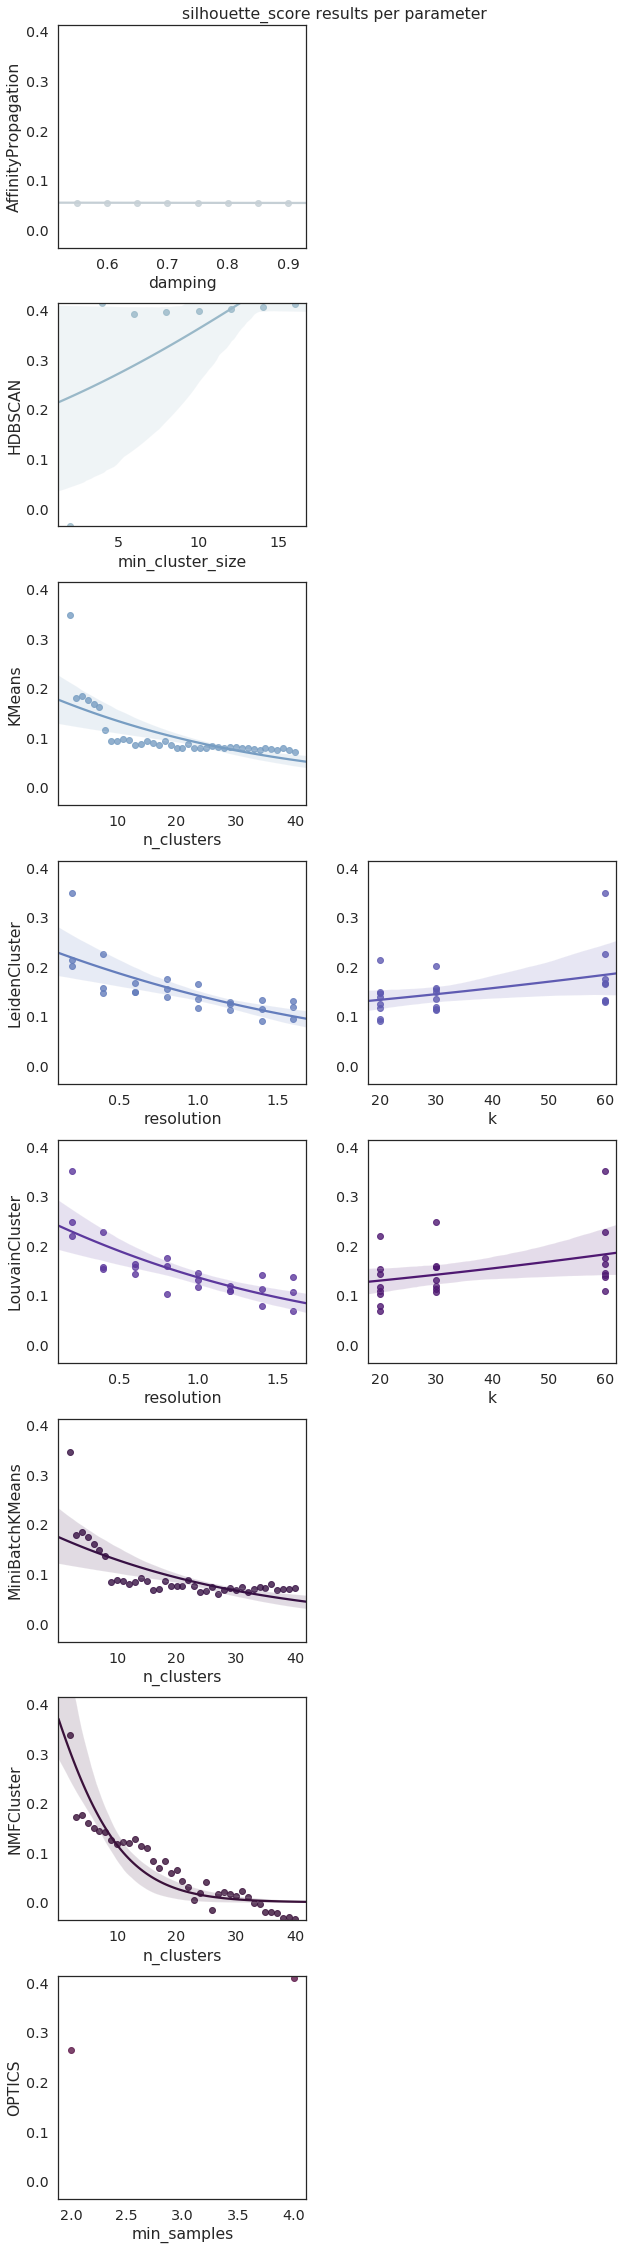

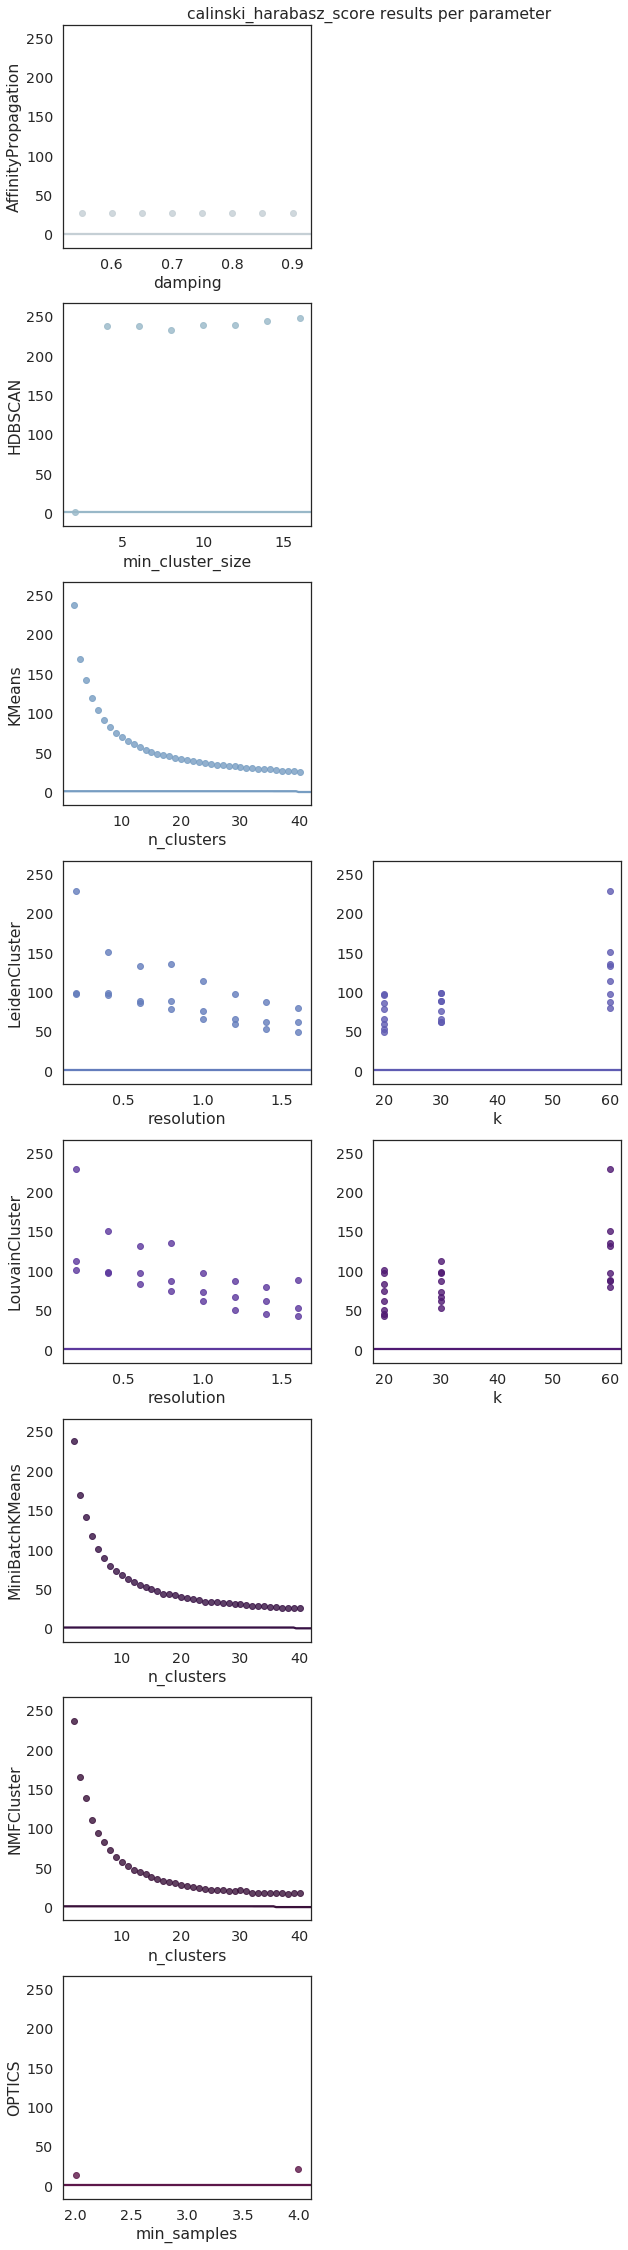

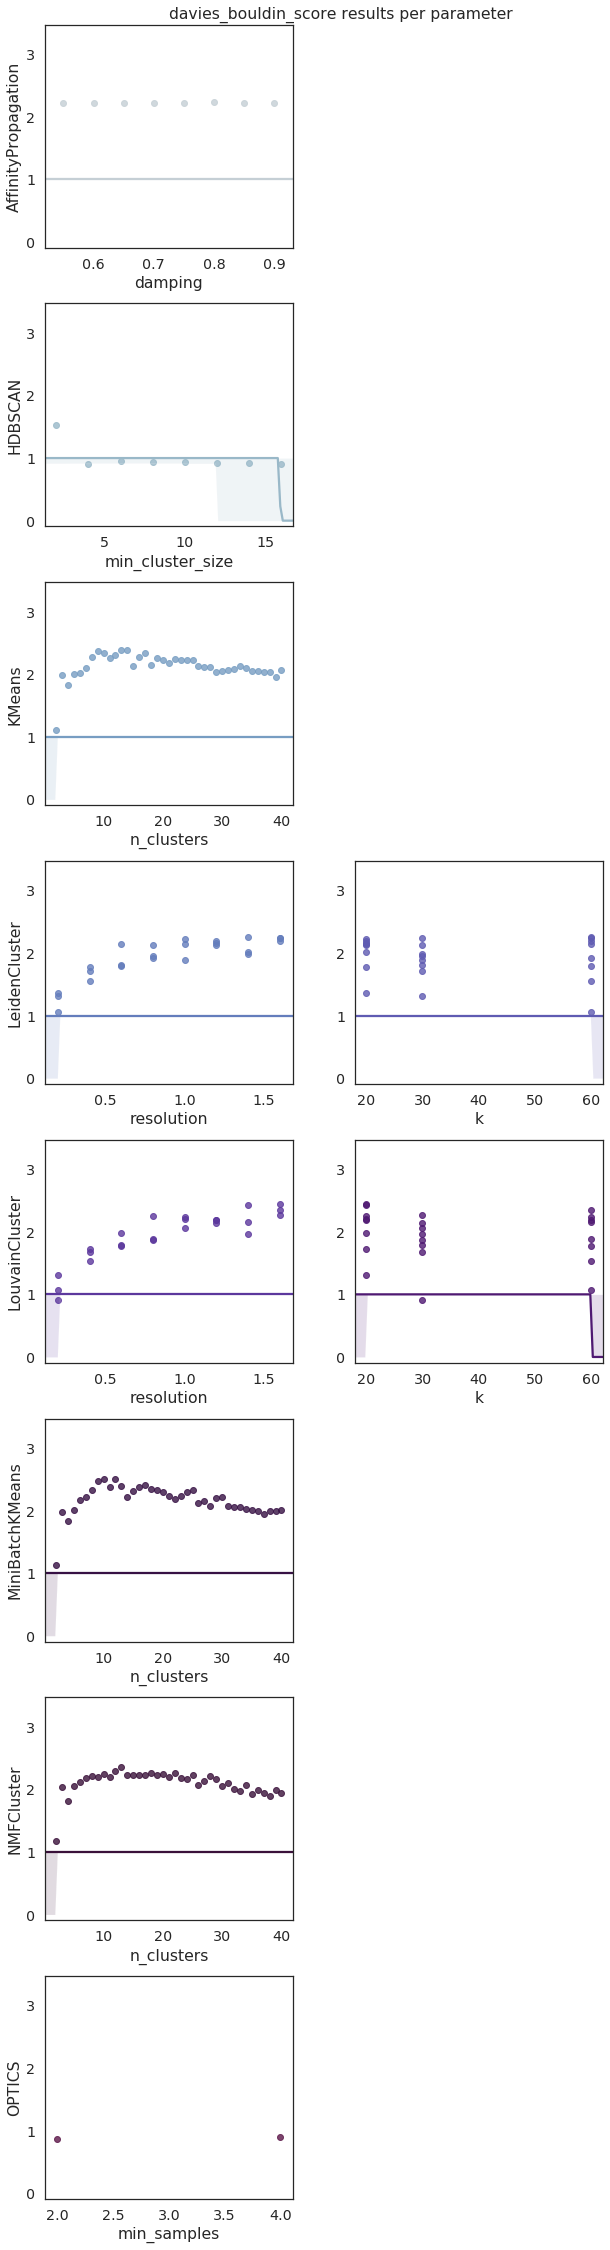

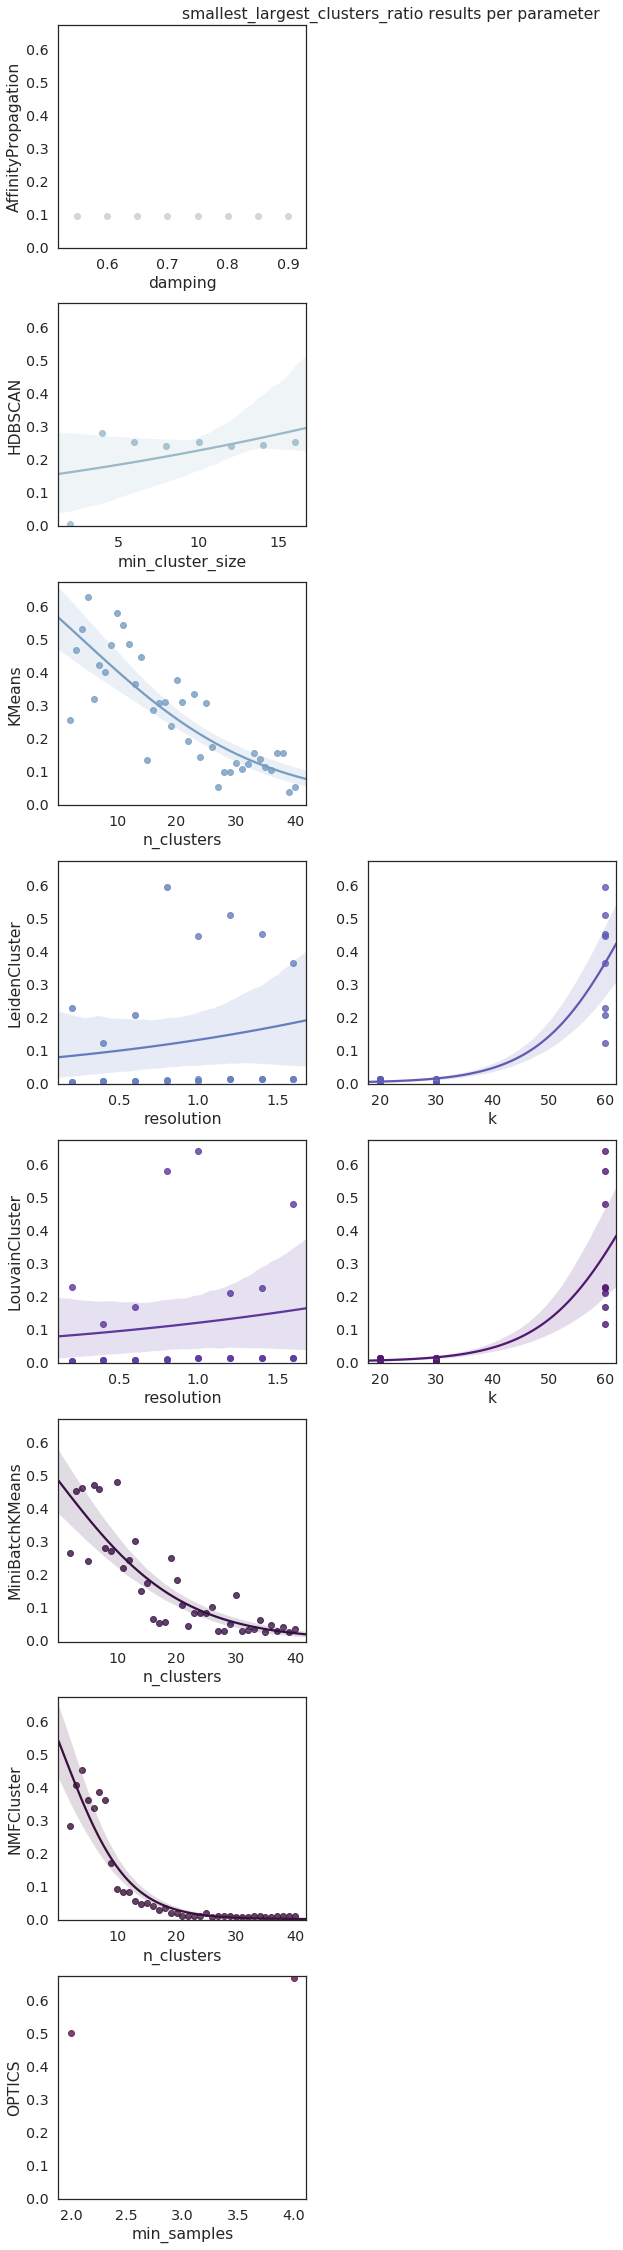

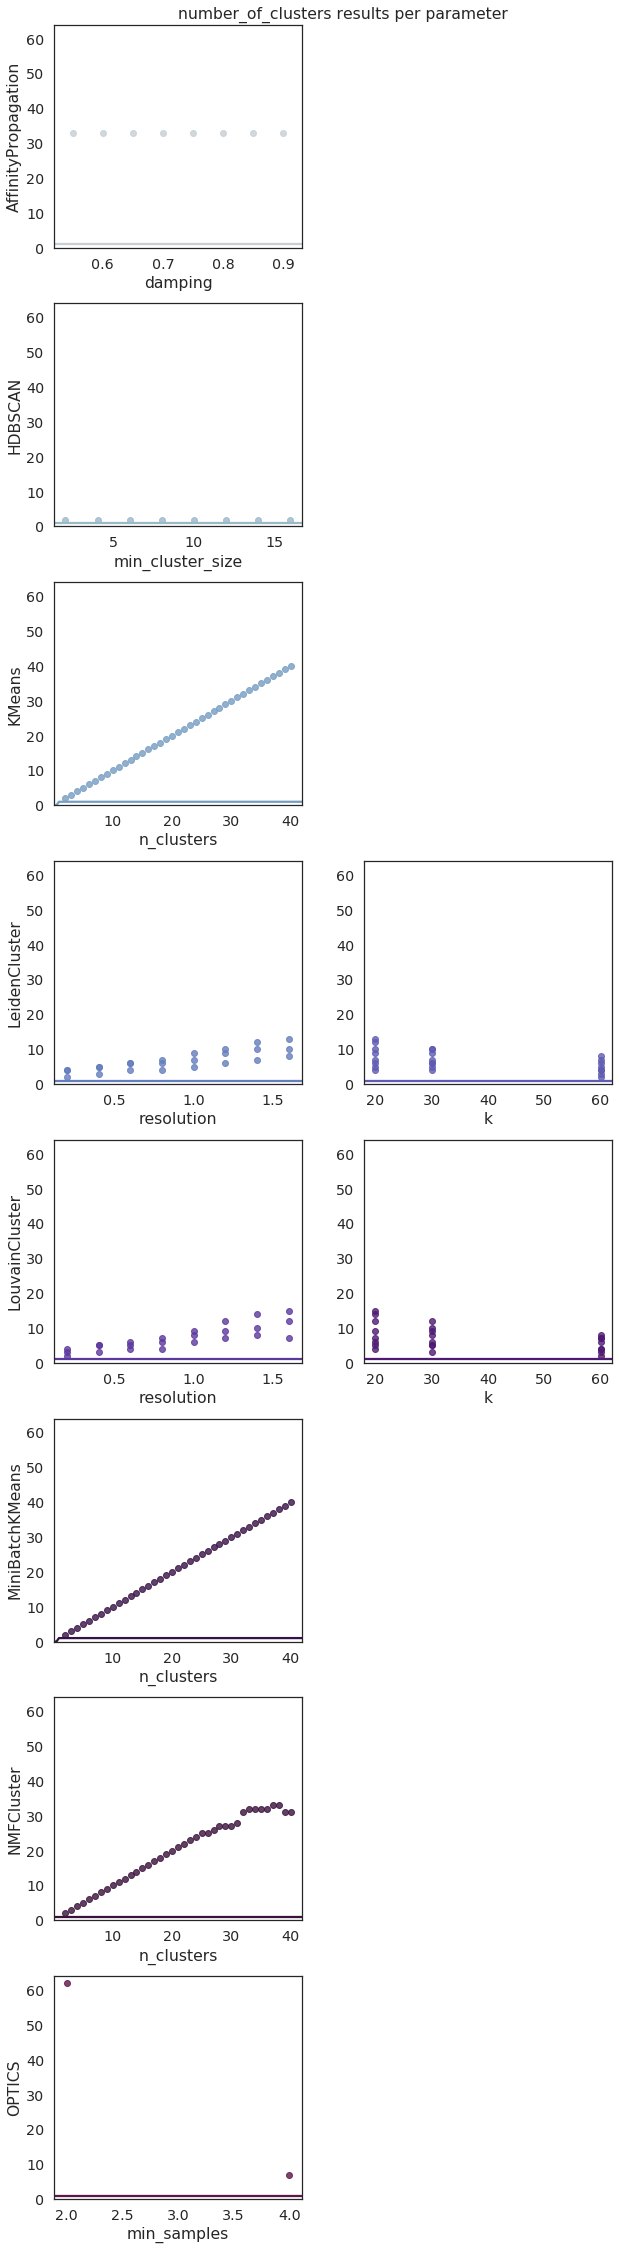

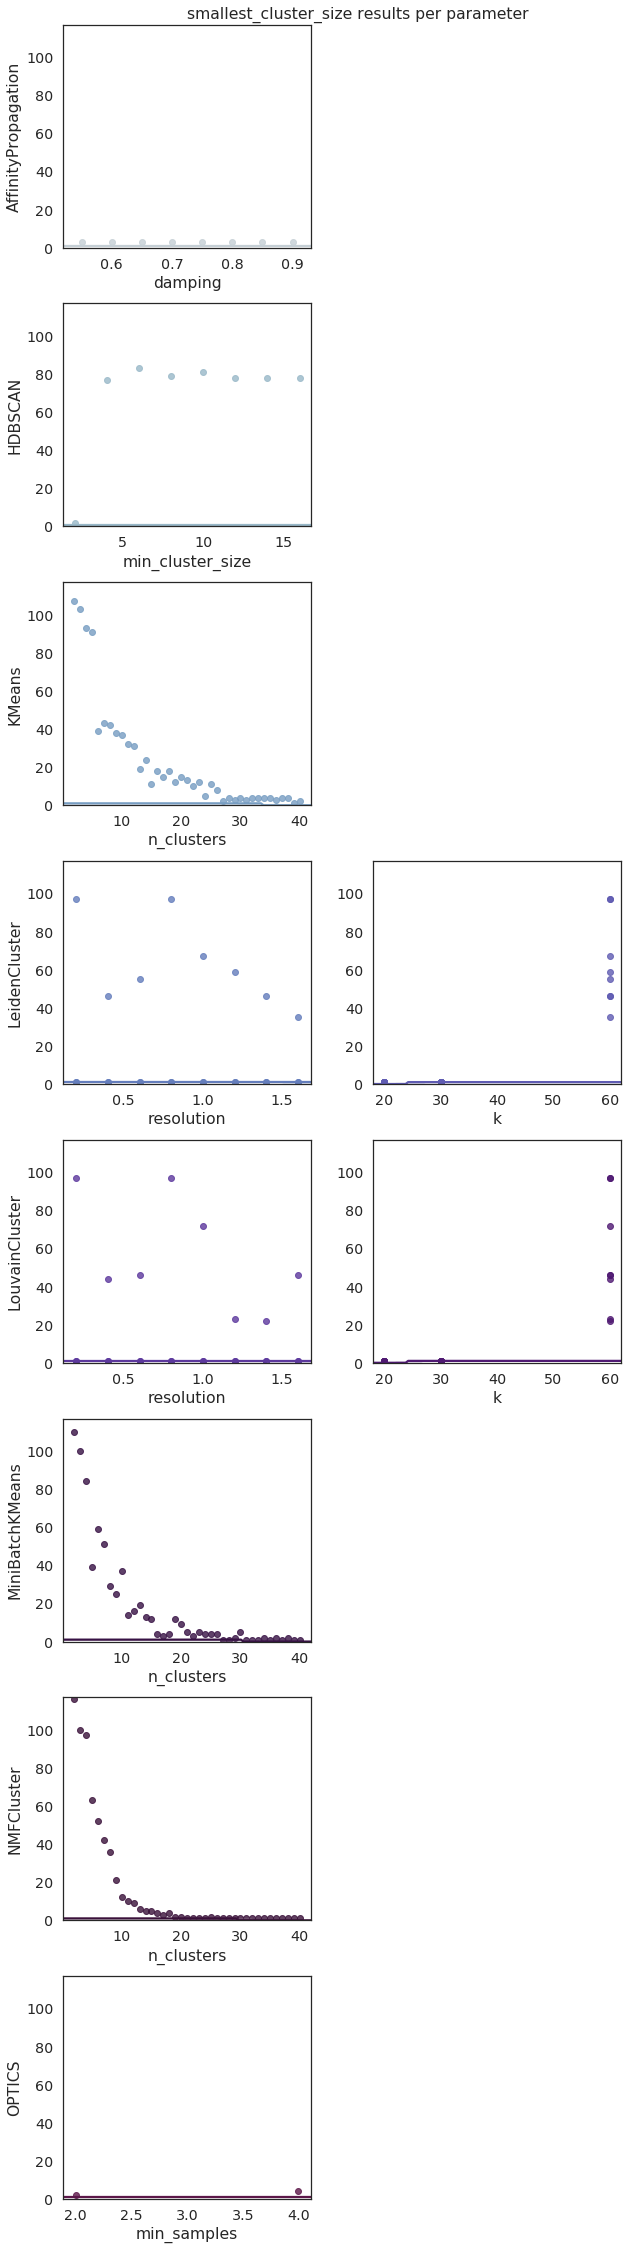

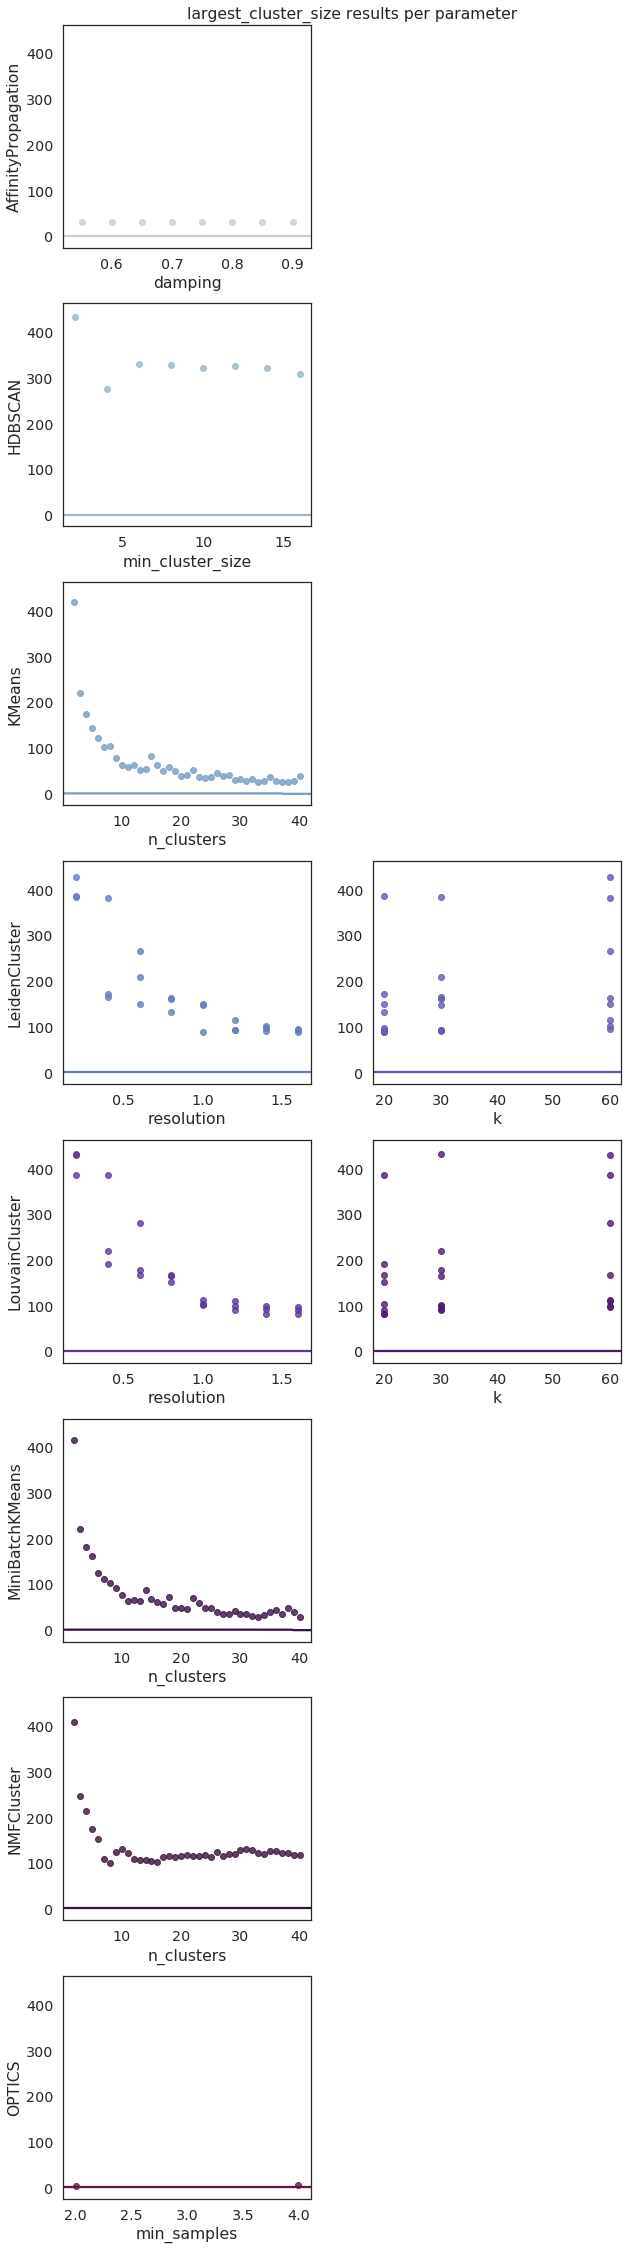

In [46]:
for metric in hc.constants.inherent_metrics:
    clusterer.visualize_for_picking_labels(metric, savefig_prefix='figures/scatter.brca-pca.%s' % metric)

In [95]:
all_clustered = clusterer.labels_df.columns[~(clusterer.labels_df==-1).any()]
labels = hc.utilities.pick_best_labels(clusterer.evaluation_df[all_clustered], clusterer.labels_df[all_clustered], 'adjusted_rand_score').replace({3.0:4.0, 4.0:3.0})

annotations = pd.concat([labels, annotations[['PAM50_SUBTYPE']]], join='inner', axis=1).sort_values(list(labels.columns)+['PAM50_SUBTYPE'])

In [96]:
colors = {
    'Luminal A': '#3A53A5',
    'CLDN-low':'#EFC032',
    'HER2-enriched':'#B9539F',
    'Basal-like':'#EE2025',
    'Normal':'gray',
    'Luminal B':'#6ECDDE',
    'nan':'#FFFFFF',
    'Normal-like':'#BDBDBD',
    0: '#3A53A5',
    1: '#B9539F',
    2: '#6ECDDE',
    3: 'purple',
    4:'#EE2025',
    5: 'green'
}

col_colors = annotations.replace(colors)

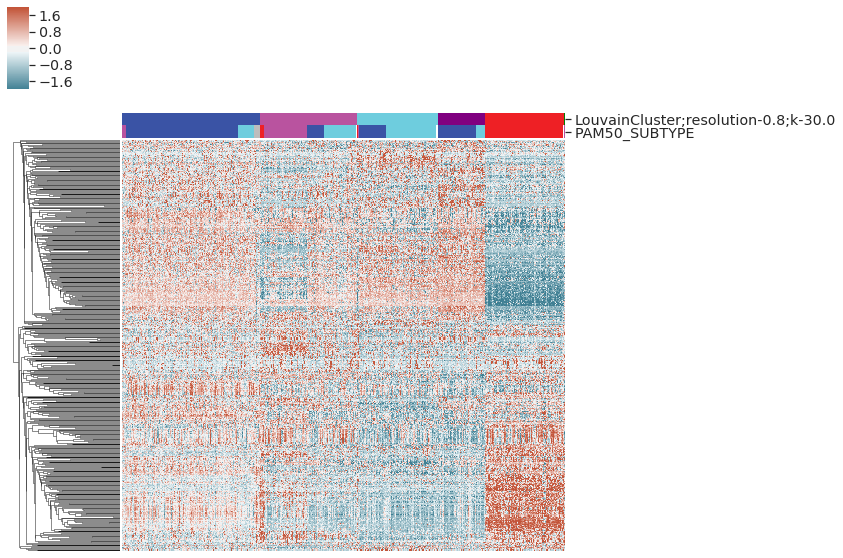

In [104]:
cg = sns.clustermap(
    hc.visualize.zscore(data.transpose().reindex(annotations.index, axis=1)),
    col_cluster=False,
    xticklabels=False, 
    yticklabels=False, 
    col_colors=col_colors, 
    cmap=sns.diverging_palette(220, 20, sep=20, as_cmap=True), 
    vmin=-2, vmax=2
)
cg.ax_heatmap.set_ylabel('')
cg.savefig('figures/clustermap.brca-pca.louvain-0.8-30-vs-pam50.pdf')